# Which COVID-19 Vaccine is Best for You?
## DS4A Team 55 Preliminary EDA


In [1]:
import pandas as pd
import numpy as np
import math
import base64
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
import zipfile

In [2]:
# increase the size and quality of any plots we produce
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 300

## state_vax.csv
Vaccine administration data for states within the U.S., including the District of Columbia from 12/13/2020 to the present, updated daily. 

In [3]:
client = Socrata(
        domain = "data.cdc.gov",
        app_token = "bsYMLkKAQhIIVd7wzBzp5BiCR",
        timeout=10
        )
results = client.get_all("unsk-b7fc")

# convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df.sample(10)

,date,mmwr_week,location,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_unk_manuf,dist_per_100k,distributed_per_100k_12plus,...,administered_dose1_recip_5pluspop_pct,series_complete_5plus,series_complete_5pluspop_pct,administered_5plus,admin_per_100k_5plus,distributed_per_100k_5plus,series_complete_moderna_5plus,series_complete_pfizer_5plus,series_complete_janssen_5plus,series_complete_unk_manuf_5plus
22451,2021-02-22T00:00:00.000,8,FL,5120975,0,0,0,0,23843,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
17251,2021-05-13T00:00:00.000,19,WY,491795,32100,238760,220935,0,84974,100219,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2840,2021-12-22T00:00:00.000,51,US,609035545,29323200,221831040,357881305,0,183440,214812,...,77.4,204808686,65.6,498965327,159789,195038,73253589,115156121,16262004,136972
13061,2021-07-17T00:00:00.000,28,UT,3299590,172400,1390460,1736730,0,102921,127286,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
20967,2021-03-17T00:00:00.000,11,WI,2542555,70300,1253700,1218555,0,43668,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3864,2021-12-06T00:00:00.000,49,VI,127400,2200,33940,91260,0,119861,142466,...,61.1,52398,52.6,122015,122476,127881,14807,35806,1780,5
22270,2021-02-25T00:00:00.000,8,UT,787680,0,0,0,0,24569,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
18,2022-02-04T00:00:00.000,5,AS,92810,600,21500,70710,0,195835,251402,...,95,37589,87.2,84392,195760,215286,9008,27999,570,12
21789,2021-03-05T00:00:00.000,9,PR,1230670,26700,621700,582270,0,38534,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
8880,2021-09-19T00:00:00.000,38,AL,6545280,293300,2934940,3317040,0,133490,156328,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN


In [4]:
# df.shape

In [5]:
# remove all distribution cols
# remove "Administered", this is the total for 1st dose and complete series
# remove all 5plus cols, very recently approved and sporadic across states
# remove additional doses for 50plus, age group doesn't show up elsewhere in dataset


df = df.drop(columns= ["mmwr_week","distributed", "distributed_janssen", "distributed_moderna", 
                       "distributed_pfizer", "distributed_unk_manuf", "dist_per_100k","distributed_per_100k_12plus",
                       "distributed_per_100k_18plus", "distributed_per_100k_65plus", "distributed_per_100k_5plus",
                       "administered","administered_dose1_recip_5plus", "recip_administered",
                       "administered_dose1_recip_5pluspop_pct", "series_complete_5plus", "series_complete_5pluspop_pct", 
                       "administered_5plus", "admin_per_100k_5plus", "series_complete_moderna_5plus",
                       "series_complete_pfizer_5plus", "series_complete_janssen_5plus", "series_complete_unk_manuf_5plus",
                       "additional_doses_50plus", "additional_doses_50plus_vax_pct"], axis=1)

In [6]:
# abbreviating column names for readability
# cols in api data are labelled differently than csv directly from data.cdc.gov, values match up so renaming those cols

rename_cols = {"administered_12plus":"admin_12plus",
               "location":"state",
               "administered_18plus":"admin_18plus",
               "administered_65plus":"admin_65plus",
               "administered_janssen":"admin_janssen",
               "administered_moderna":"admin_moderna",
               "administered_pfizer":"admin_pfizer",
               "administered_unk_manuf":"admin_unk",
               "administered_dose1_recip":"admin_dose1",
               "administered_dose1_pop_pct":"admin_dose1_pop_pct",
               "administered_dose1_recip_1":"admin_dose1_12plus",
               "administered_dose1_recip_2":"admin_dose1_12plus_pop_pct",
               "administered_dose1_recip_3":"admin_dose1_18plus",
               "administered_dose1_recip_4":"admin_dose1_18plus_pop_pct",
               "administered_dose1_recip_5":"admin_dose1_65plus",
               "administered_dose1_recip_6":"admin_dose1_65plus_pop_pct",
               "series_complete_yes":"series_complete",
               "series_complete_12pluspop":"series_complete_12plus_pop_pct",
               "series_complete_18pluspop":"series_complete_18plus_pop_pct",
               "series_complete_65pluspop":"series_complete_65plus_pop_pct",
               "series_complete_unk_manuf":"series_complete_unk",
               "series_complete_unk_manuf_1":"series_complete_unk_12plus",
               "series_complete_unk_manuf_2":"series_complete_unk_18plus",
               "series_complete_unk_manuf_3":"series_complete_unk_65plus",
               "series_complete_12pluspop_pct":"series_complete_12plus_pop_pct",
               "series_complete_18pluspop_pct":"series_complete_18plus_pop_pct",
               "series_complete_65pluspop_pct":"series_complete_65plus_pop_pct"
               }
df = df.rename(columns=rename_cols)

In [7]:
# df.columns

In [8]:
# see data types of df
# all types = object, need to change to ints and floats
# df.dtypes

In [9]:
# show cols with NaNs
# cols with NaNs are additional dose cols, after investigating this happens when other additional dose cols are 0
df.columns[df.isnull().any()]

Index(['additional_doses', 'additional_doses_vax_pct',
       'additional_doses_12plus', 'additional_doses_12plus_vax_pct',
       'additional_doses_18plus', 'additional_doses_18plus_vax_pct',
       'additional_doses_65plus', 'additional_doses_65plus_vax_pct',
       'additional_doses_moderna', 'additional_doses_pfizer',
       'additional_doses_janssen', 'additional_doses_unk_manuf'],
      dtype='object')

In [10]:
# replace NaNs with 0 to fill in values
nan_col = ['additional_doses', 'additional_doses_vax_pct', 'additional_doses_12plus',
           'additional_doses_18plus', 'additional_doses_12plus_vax_pct', 'additional_doses_18plus_vax_pct',
           'additional_doses_65plus', 'additional_doses_65plus_vax_pct',
           'additional_doses_moderna', 'additional_doses_pfizer',
           'additional_doses_janssen', 'additional_doses_unk_manuf']
df[nan_col] = df[nan_col].fillna(0)

In [11]:
to_int = ['admin_12plus', 'admin_18plus', 'admin_65plus','admin_janssen',
          'admin_moderna', 'admin_pfizer', 'admin_unk','admin_per_100k',
          'admin_per_100k_12plus', 'admin_per_100k_18plus','admin_per_100k_65plus',
          'admin_dose1', 'admin_dose1_12plus', 'admin_dose1_18plus',
          'admin_dose1_65plus', 'series_complete_12plus', 'series_complete_18plus',
          'series_complete','series_complete_65plus', 'series_complete_janssen', 'series_complete_moderna',
          'series_complete_pfizer','series_complete_unk', 'series_complete_janssen_12plus',
          'series_complete_moderna_12plus', 'series_complete_pfizer_12plus', 'series_complete_unk_12plus',
          'series_complete_janssen_18plus', 'series_complete_moderna_18plus', 'series_complete_pfizer_18plus',
          'series_complete_unk_18plus', 'series_complete_janssen_65plus', 'series_complete_moderna_65plus',
          'series_complete_pfizer_65plus', 'series_complete_unk_65plus', 'additional_doses', 'additional_doses_12plus',
          'additional_doses_18plus', 'additional_doses_65plus', 'additional_doses_moderna',
          'additional_doses_pfizer', 'additional_doses_janssen', 'additional_doses_unk_manuf'
         ]

to_float = ['admin_dose1_pop_pct', 'admin_dose1_12plus_pop_pct', 'admin_dose1_18plus_pop_pct',
            'admin_dose1_65plus_pop_pct', 'series_complete_pop_pct', 'series_complete_12plus_pop_pct',
            'series_complete_12plus_pop_pct', 'series_complete_18plus_pop_pct', 'series_complete_65plus_pop_pct',
            'additional_doses_vax_pct', 'additional_doses_12plus_vax_pct', 'additional_doses_18plus_vax_pct', 'additional_doses_65plus_vax_pct'
           ]

df[to_int] = df[to_int].astype("int")
df[to_float] = df[to_float].astype("float")

In [12]:
# checking that data types hace been converted correctly
# df.dtypes

In [13]:
# removing locations outside of the contential united states as well as united states total

drop_location = ["AS", "BP2", "DD2", "FM", "GU",
                 "IH2", "MH", "MP", "PR", "RP",
                 "US", "VA2", "VI", "LTC"]
df = df[~df["state"].isin(drop_location)]

# checking that location vals = 51, including DC

df.state.nunique()

52

In [14]:
# converting "date" col to datetime
df["date"] = pd.to_datetime(df["date"])

In [15]:
# filter location to New York
df_ny = df.loc[df["state"] == "NY"]

In [16]:
# creating a new df with all values on a daily basis instead of a running total
df_ny_daily = df_ny.drop(columns="state").set_index("date")
df_ny_daily = df_ny_daily.diff(periods=-1, axis=0)
df_ny_daily.head(50)

,admin_12plus,admin_18plus,admin_65plus,admin_janssen,admin_moderna,admin_pfizer,admin_unk,admin_per_100k,admin_per_100k_12plus,admin_per_100k_18plus,...,additional_doses_12plus,additional_doses_12plus_vax_pct,additional_doses_18plus,additional_doses_18plus_vax_pct,additional_doses_65plus,additional_doses_65plus_vax_pct,additional_doses_moderna,additional_doses_pfizer,additional_doses_janssen,additional_doses_unk_manuf
date,,,,,,,,,,,,,,,,,,,,,
2022-02-04,46162.0,42061.0,6038.0,1046.0,15975.0,35844.0,71.0,272.0,275.0,272.0,...,25346.0,0.2,23505.0,0.2,4022.0,0.1,9659.0,15746.0,496.0,6.0
2022-02-03,43152.0,38981.0,5802.0,1176.0,15193.0,33279.0,94.0,255.0,258.0,253.0,...,22984.0,0.1,21168.0,0.1,3840.0,0.1,9048.0,13455.0,486.0,1.0
2022-02-02,49261.0,43520.0,5749.0,1120.0,15910.0,39955.0,65.0,294.0,293.0,282.0,...,26452.0,0.2,23627.0,0.2,3802.0,0.1,9491.0,16444.0,522.0,2.0
2022-02-01,32802.0,29186.0,3318.0,783.0,10536.0,25578.0,66.0,190.0,196.0,189.0,...,17344.0,0.1,15397.0,0.0,2117.0,0.1,6179.0,10827.0,342.0,1.0
2022-01-31,17424.0,14387.0,1130.0,377.0,5203.0,14899.0,10.0,105.0,104.0,94.0,...,10449.0,0.0,8462.0,0.1,805.0,0.0,3429.0,6872.0,149.0,0.0
2022-01-30,49846.0,42207.0,4525.0,888.0,16437.0,40187.0,24.0,296.0,297.0,273.0,...,32196.0,0.2,27294.0,0.2,3249.0,0.1,11450.0,20281.0,468.0,0.0
2022-01-29,61485.0,55269.0,7659.0,1403.0,20333.0,47749.0,117.0,357.0,366.0,359.0,...,35971.0,0.3,32669.0,0.2,5271.0,0.2,13211.0,22050.0,712.0,6.0
2022-01-28,58849.0,53267.0,7770.0,1242.0,20191.0,45159.0,90.0,343.0,351.0,345.0,...,33570.0,0.2,30765.0,0.2,5327.0,0.2,12986.0,20009.0,569.0,8.0
2022-01-27,56316.0,50669.0,7246.0,1249.0,18474.0,44217.0,102.0,329.0,336.0,328.0,...,5764161.0,41.3,28954.0,0.2,4967.0,0.1,12033.0,19226.0,507.0,3.0


In [17]:
# this value appears as an outlier but was manually calculated from raw dataset and is correct
print(df_ny_daily["admin_pfizer"].max())

581745.0


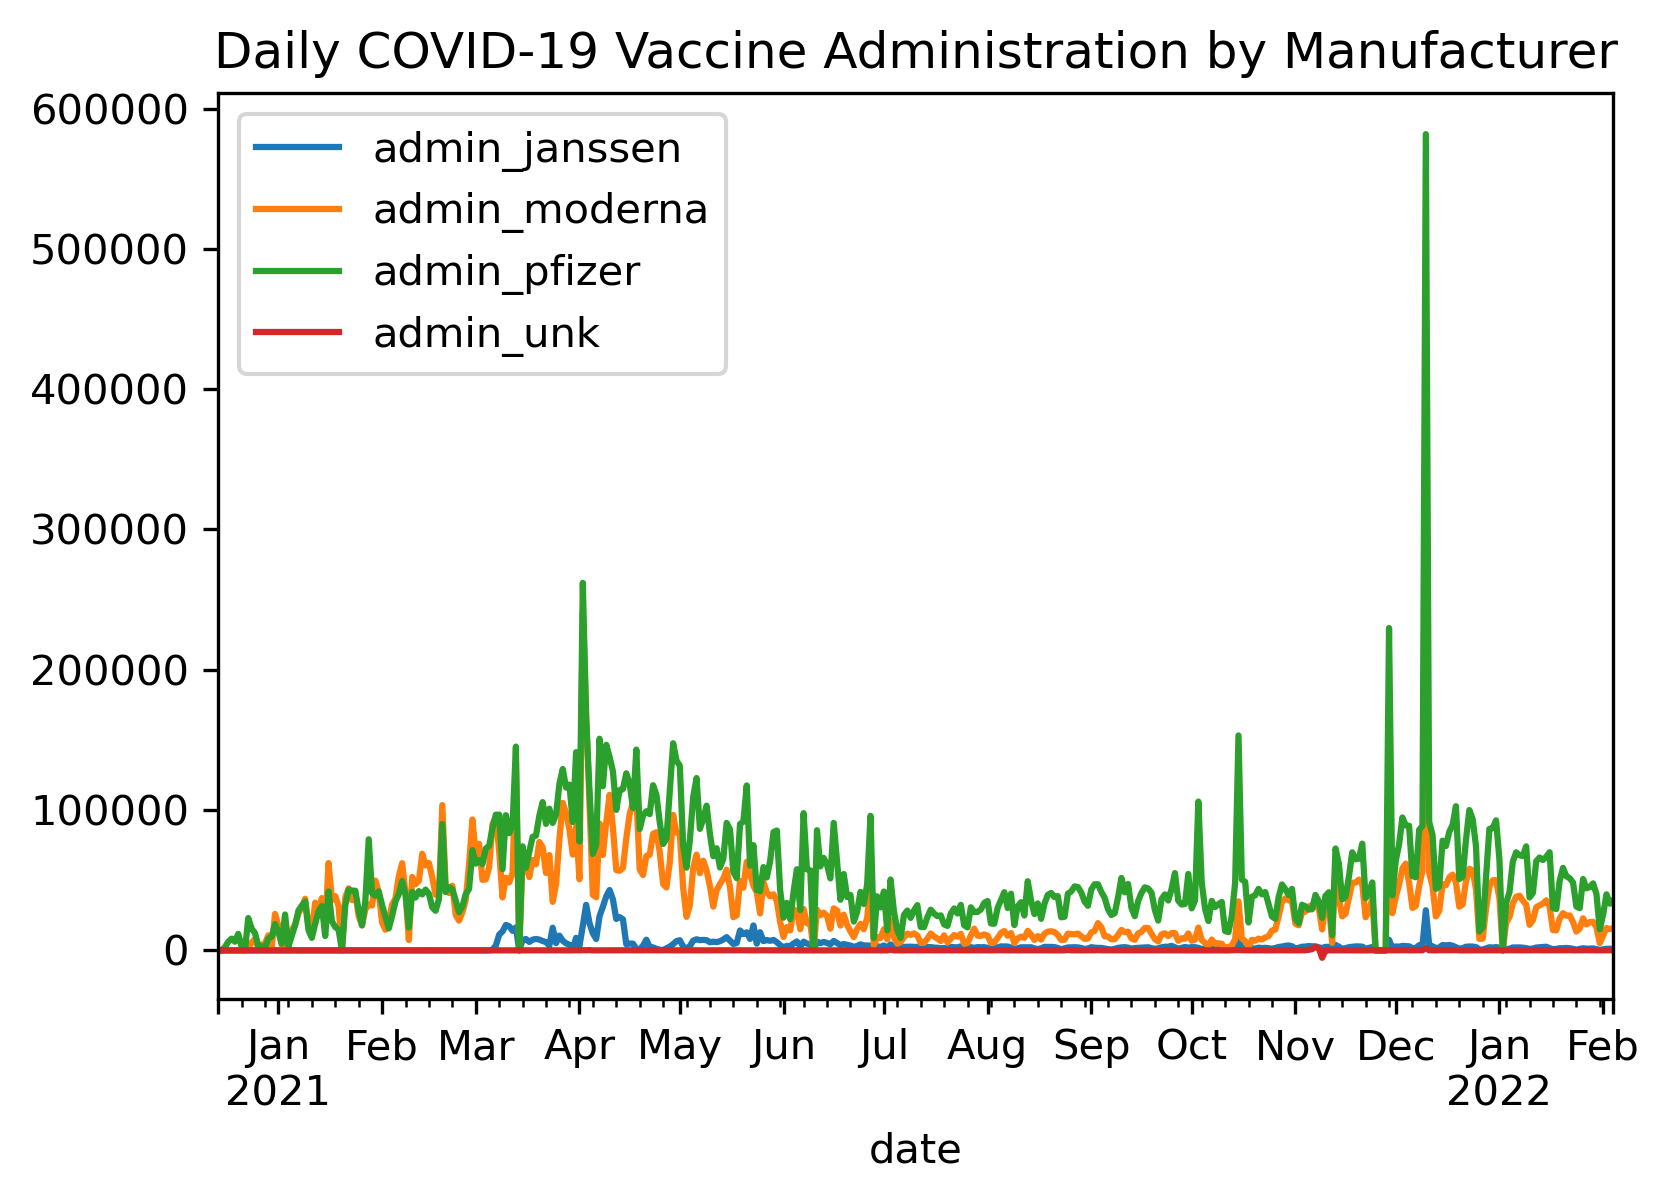

In [18]:
daily_plt = df_ny_daily.reset_index()
daily_plt.plot(x="date", y=["admin_janssen", "admin_moderna", "admin_pfizer", "admin_unk"], kind="line", title="Daily COVID-19 Vaccine Administration by Manufacturer");

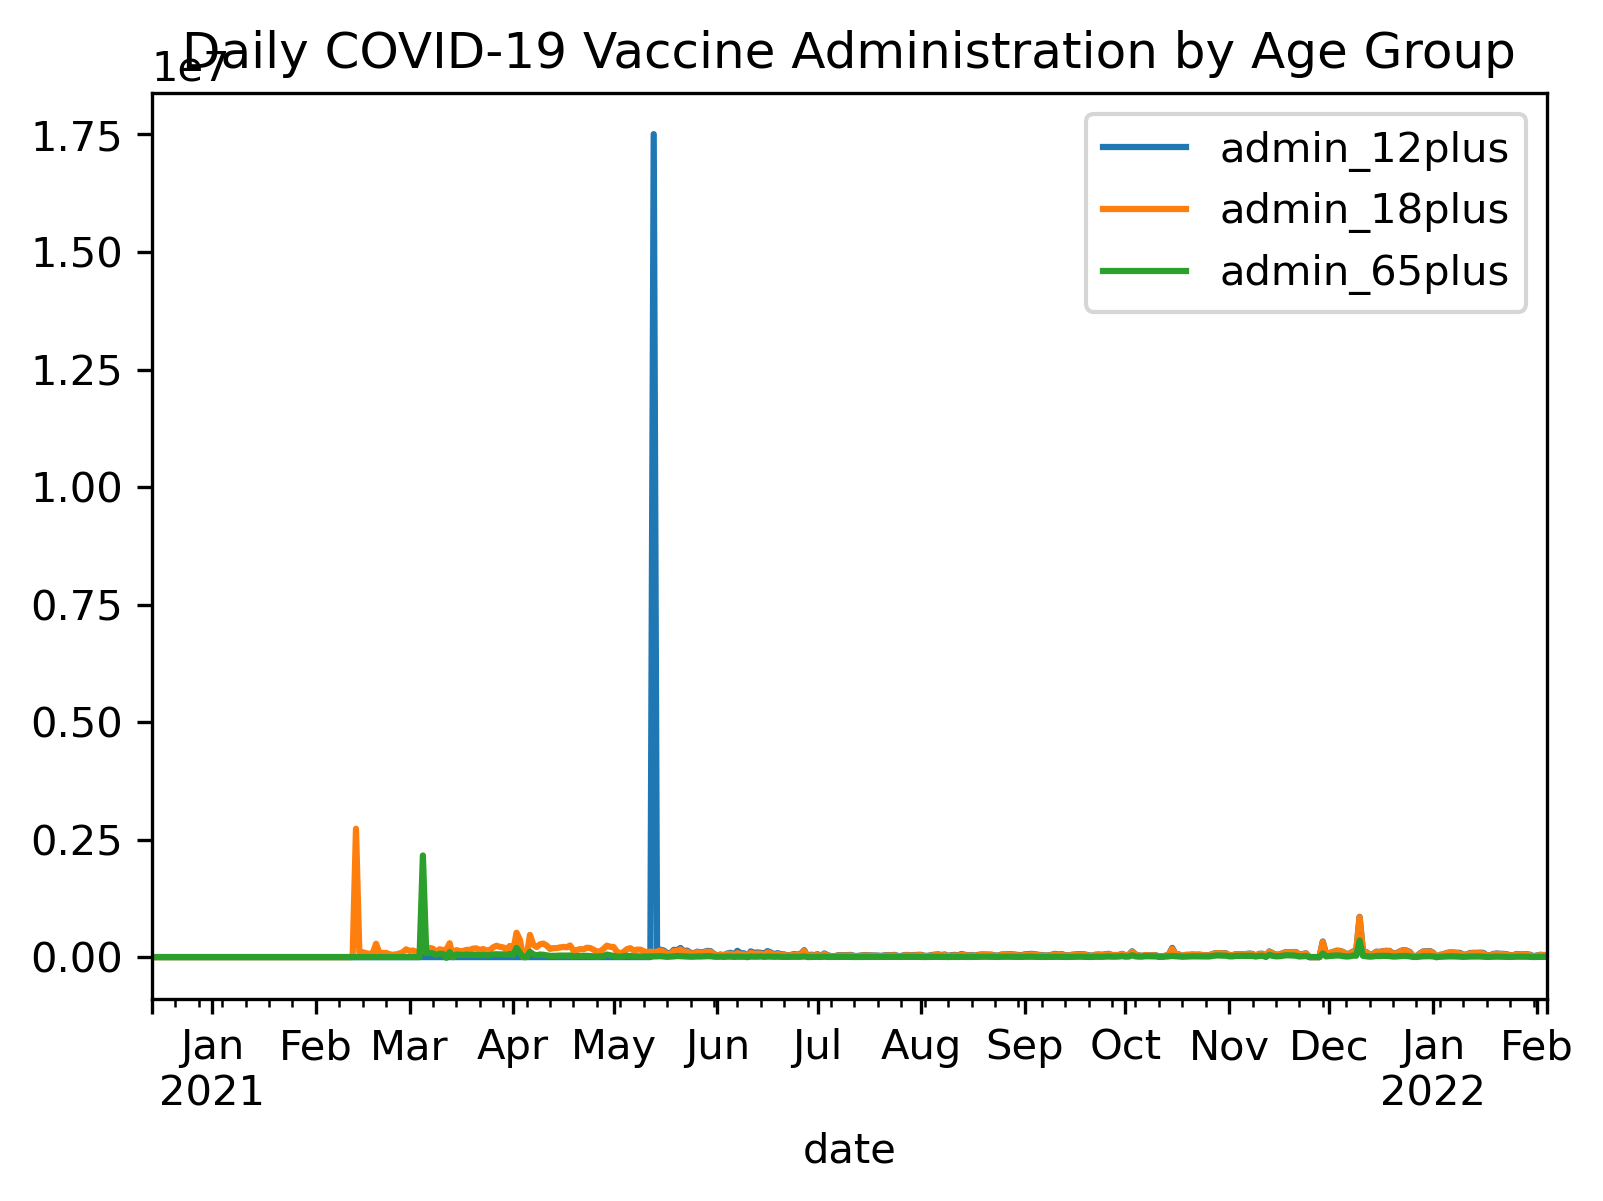

In [19]:
daily_plt.plot(x="date", y=["admin_12plus", "admin_18plus", "admin_65plus"], kind="line", title="Daily COVID-19 Vaccine Administration by Age Group");

The large spike in mid-May 2021 for the 12plus age group can be attributed to the FDA's approval of COVID-19 vaccines for this age group.

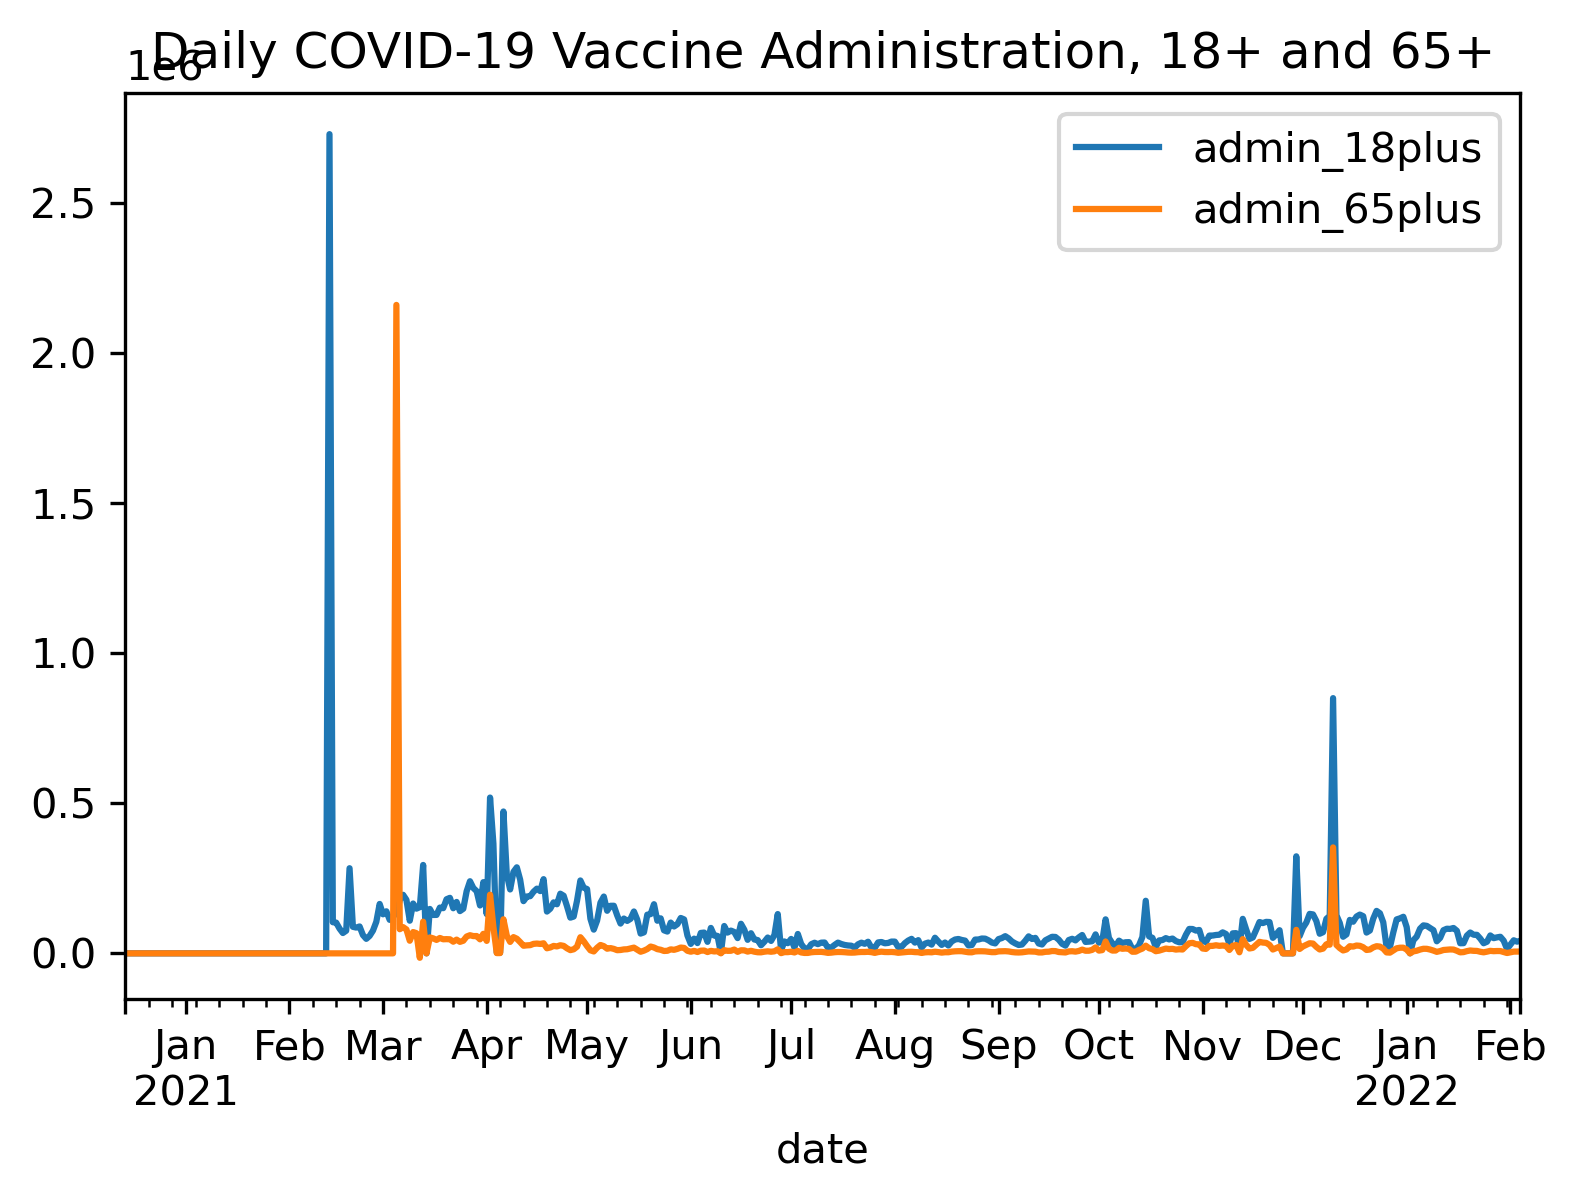

In [20]:
daily_plt.plot(x="date", y=["admin_18plus", "admin_65plus"], kind="line", title="Daily COVID-19 Vaccine Administration, 18+ and 65+");

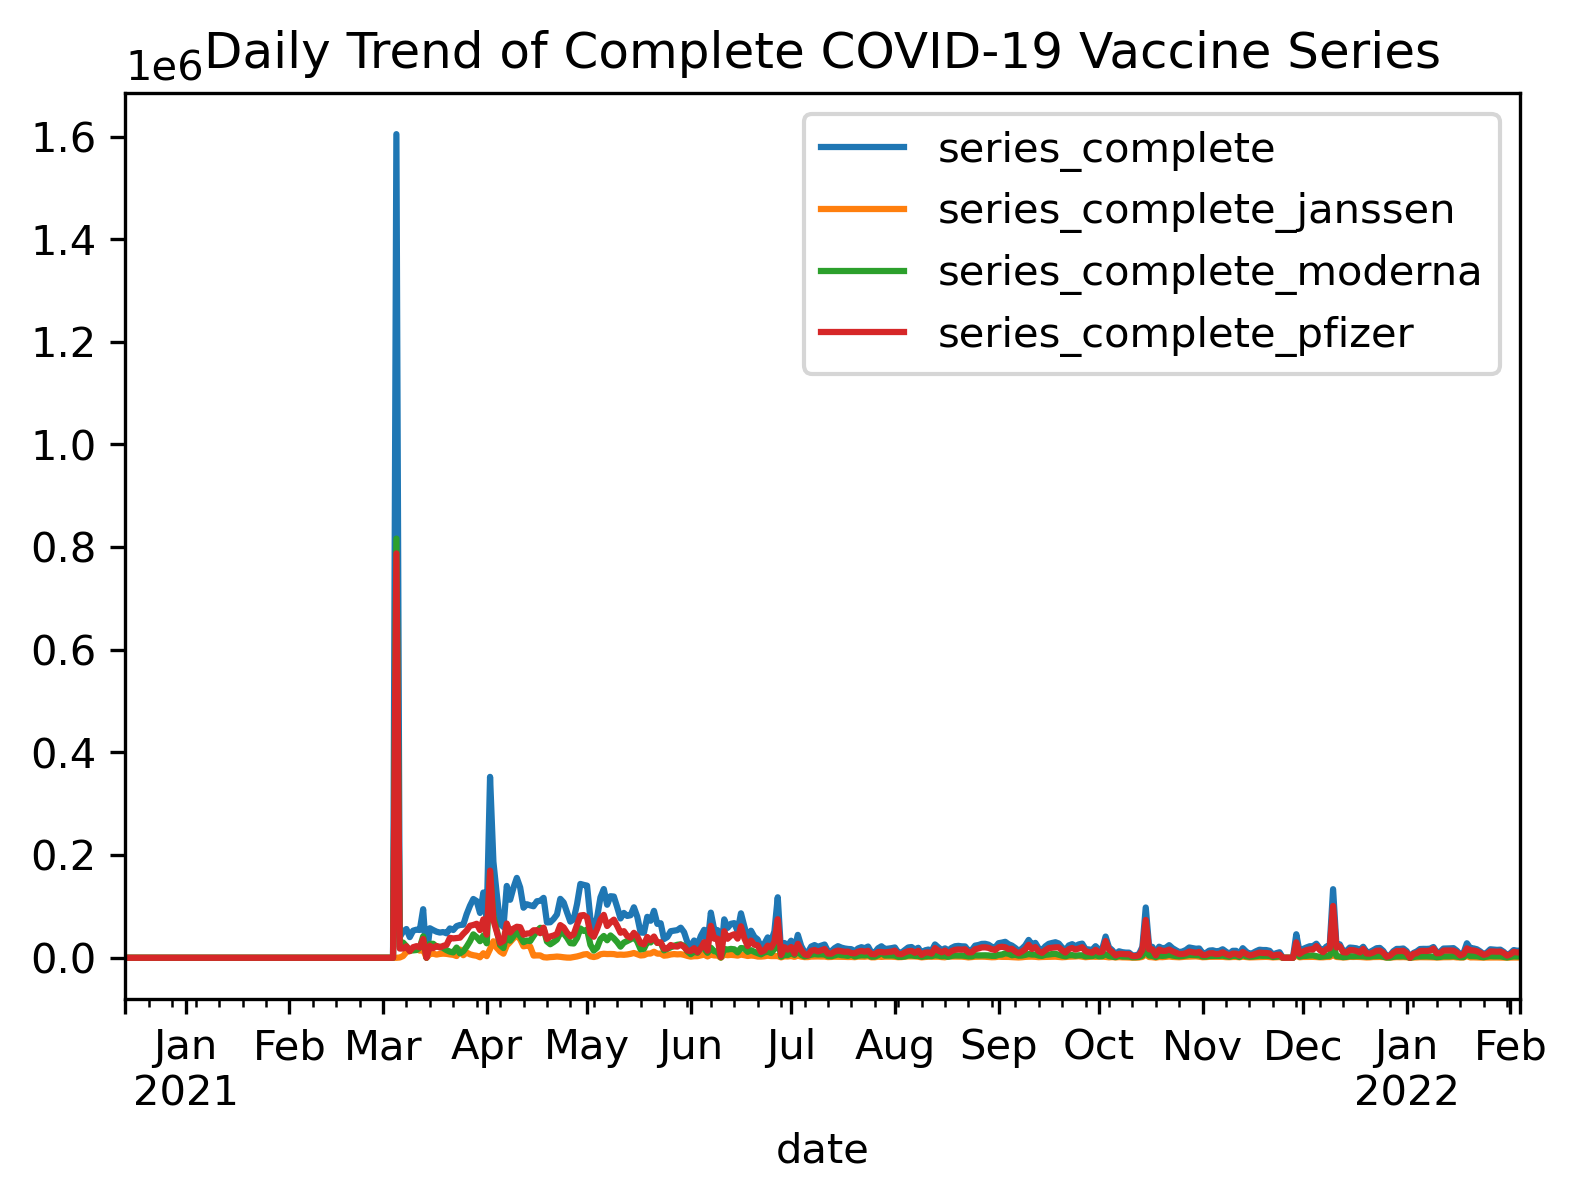

In [21]:
daily_plt.plot(x="date", y=['series_complete','series_complete_janssen', 'series_complete_moderna',
                            'series_complete_pfizer'], kind="line", title="Daily Trend of Complete COVID-19 Vaccine Series");

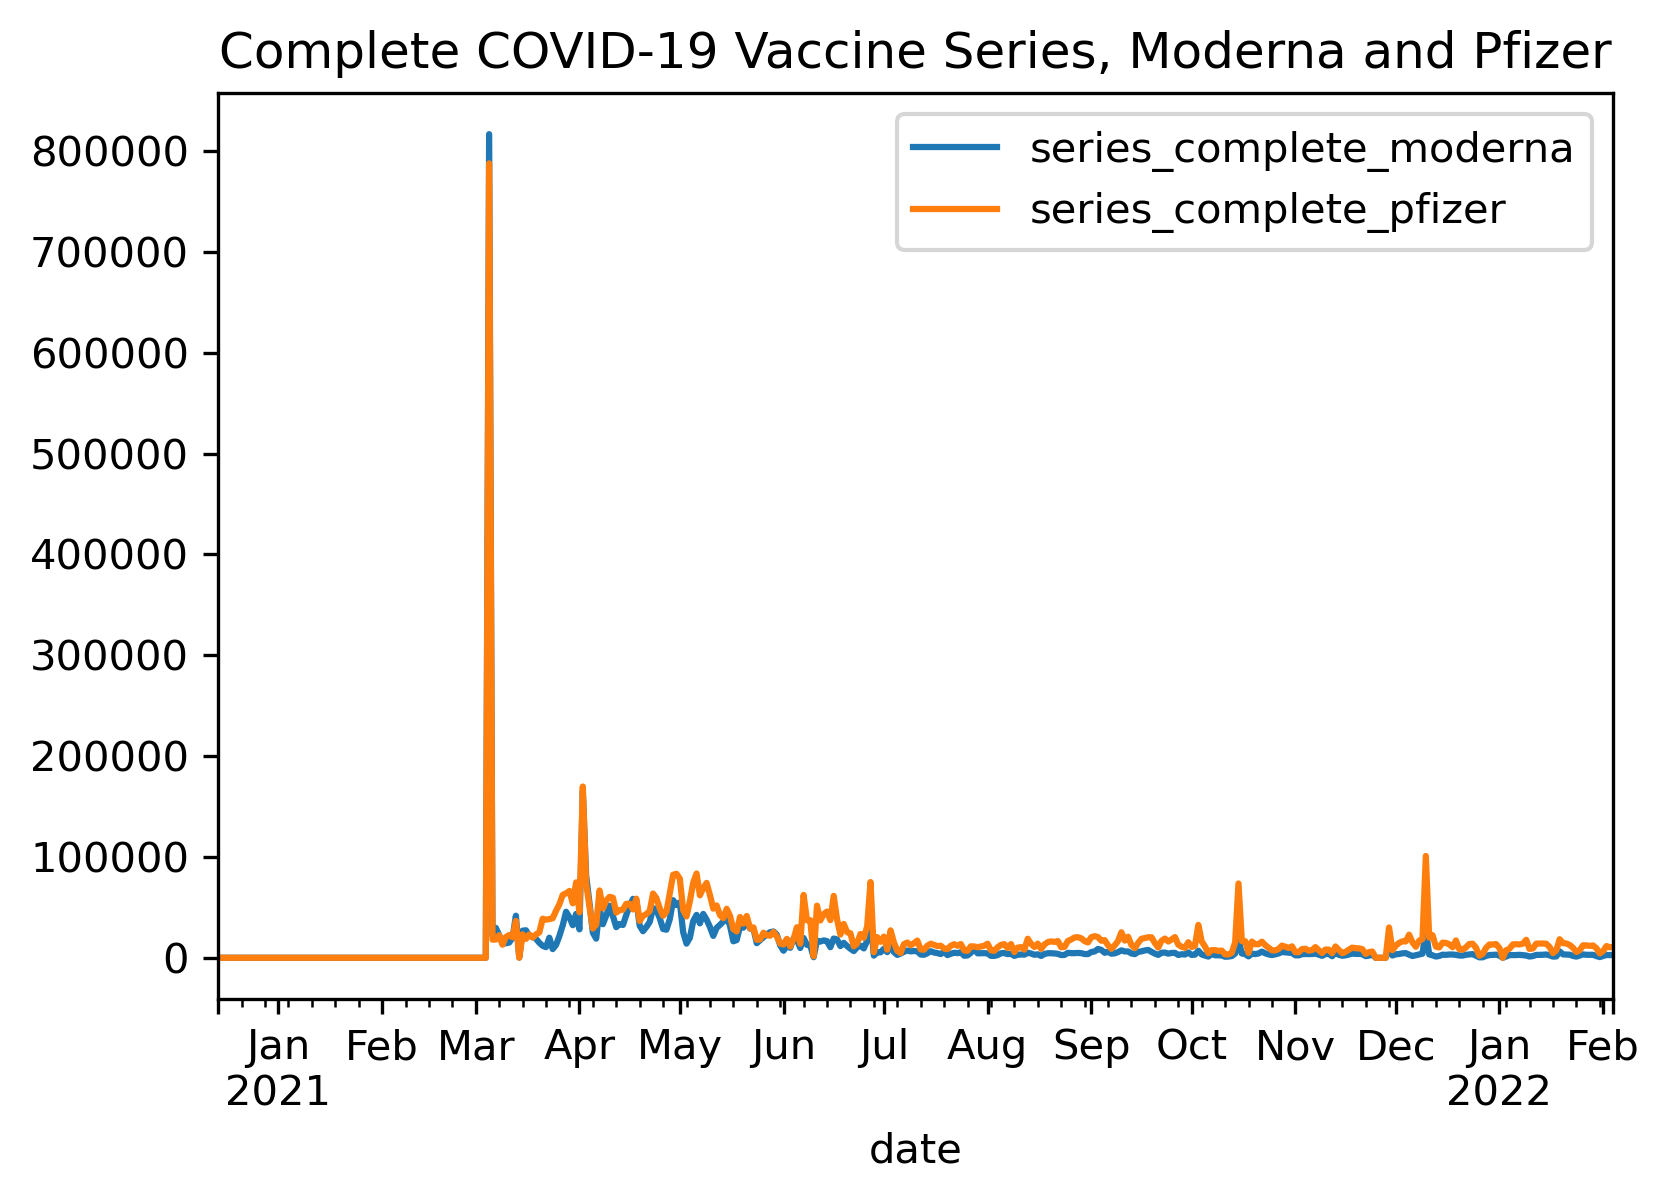

In [22]:
# because the Janssen vax is a one dose series, taking a closer look at moderna and pfizer
daily_plt.plot(x="date", y=['series_complete_moderna','series_complete_pfizer'],
               kind="line", title="Complete COVID-19 Vaccine Series, Moderna and Pfizer");


In both of the above plots, "Daily Trend of Complete COVID-19 Vaccine Series" and "Complete COVID-19 Vaccine Series, Moderna and Pfizer", a large spike can be seen in early March 2021. This is approximately the first date where a person would have the opportunity to get their final dose, since the vaccines were maded available in late January and early February of 2021

In [23]:
# set index to date to extract rows for the first of each month, aligns with how other datasets are reported
df_ny_m = df_ny.set_index("date")
df_ny_m = df_ny_m.groupby(df_ny_m.index.strftime("%Y-%m")).tail(1)
df_ny_m = df_ny_m.reset_index().sort_values(by="date", ascending=True)
df_ny_m.head(10)

,date,state,admin_12plus,admin_18plus,admin_65plus,admin_janssen,admin_moderna,admin_pfizer,admin_unk,admin_per_100k,...,additional_doses_12plus,additional_doses_12plus_vax_pct,additional_doses_18plus,additional_doses_18plus_vax_pct,additional_doses_65plus,additional_doses_65plus_vax_pct,additional_doses_moderna,additional_doses_pfizer,additional_doses_janssen,additional_doses_unk_manuf
14,2020-12-14,NY,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0,0,0
13,2021-01-01,NY,0,0,0,0,82248,146240,11,1175,...,0,0.0,0,0.0,0,0.0,0,0,0,0
12,2021-02-01,NY,0,0,0,0,943356,984098,211,9909,...,0,0.0,0,0.0,0,0.0,0,0,0,0
11,2021-03-01,NY,0,4353823,0,0,2253872,2101216,456,22389,...,0,0.0,0,0.0,0,0.0,0,0,0,0
10,2021-04-01,NY,0,9369873,3570327,216370,4309912,4865934,1268,48287,...,0,0.0,0,0.0,0,0.0,0,0,0,0
9,2021-05-01,NY,0,15705472,4733041,603095,6819234,8433328,2942,81520,...,0,0.0,0,0.0,0,0.0,0,0,0,0
8,2021-06-01,NY,19706068,19188844,5168904,828036,8151594,10723586,4162,101305,...,0,0.0,0,0.0,0,0.0,0,0,0,0
7,2021-07-01,NY,21849369,20873295,5370845,948791,8743524,12153595,5114,112324,...,0,0.0,0,0.0,0,0.0,0,0,0,0
6,2021-08-01,NY,22995942,21813875,5488352,1013560,9040360,12937436,6485,118219,...,0,0.0,0,0.0,0,0.0,0,0,0,0
5,2021-09-01,NY,24426700,22985019,5633411,1072305,9356997,13991672,7909,125575,...,0,0.0,0,0.0,0,0.0,0,0,0,0


In [24]:
# first reported date and most recent date for vax data, updated daily
print(df_ny["date"].min())
print(df_ny["date"].max())

2020-12-14 00:00:00
2022-02-04 00:00:00


<AxesSubplot:title={'center':'Rates of COVID-19 Vaccine Administration by Manufacturer'}, xlabel='date'>

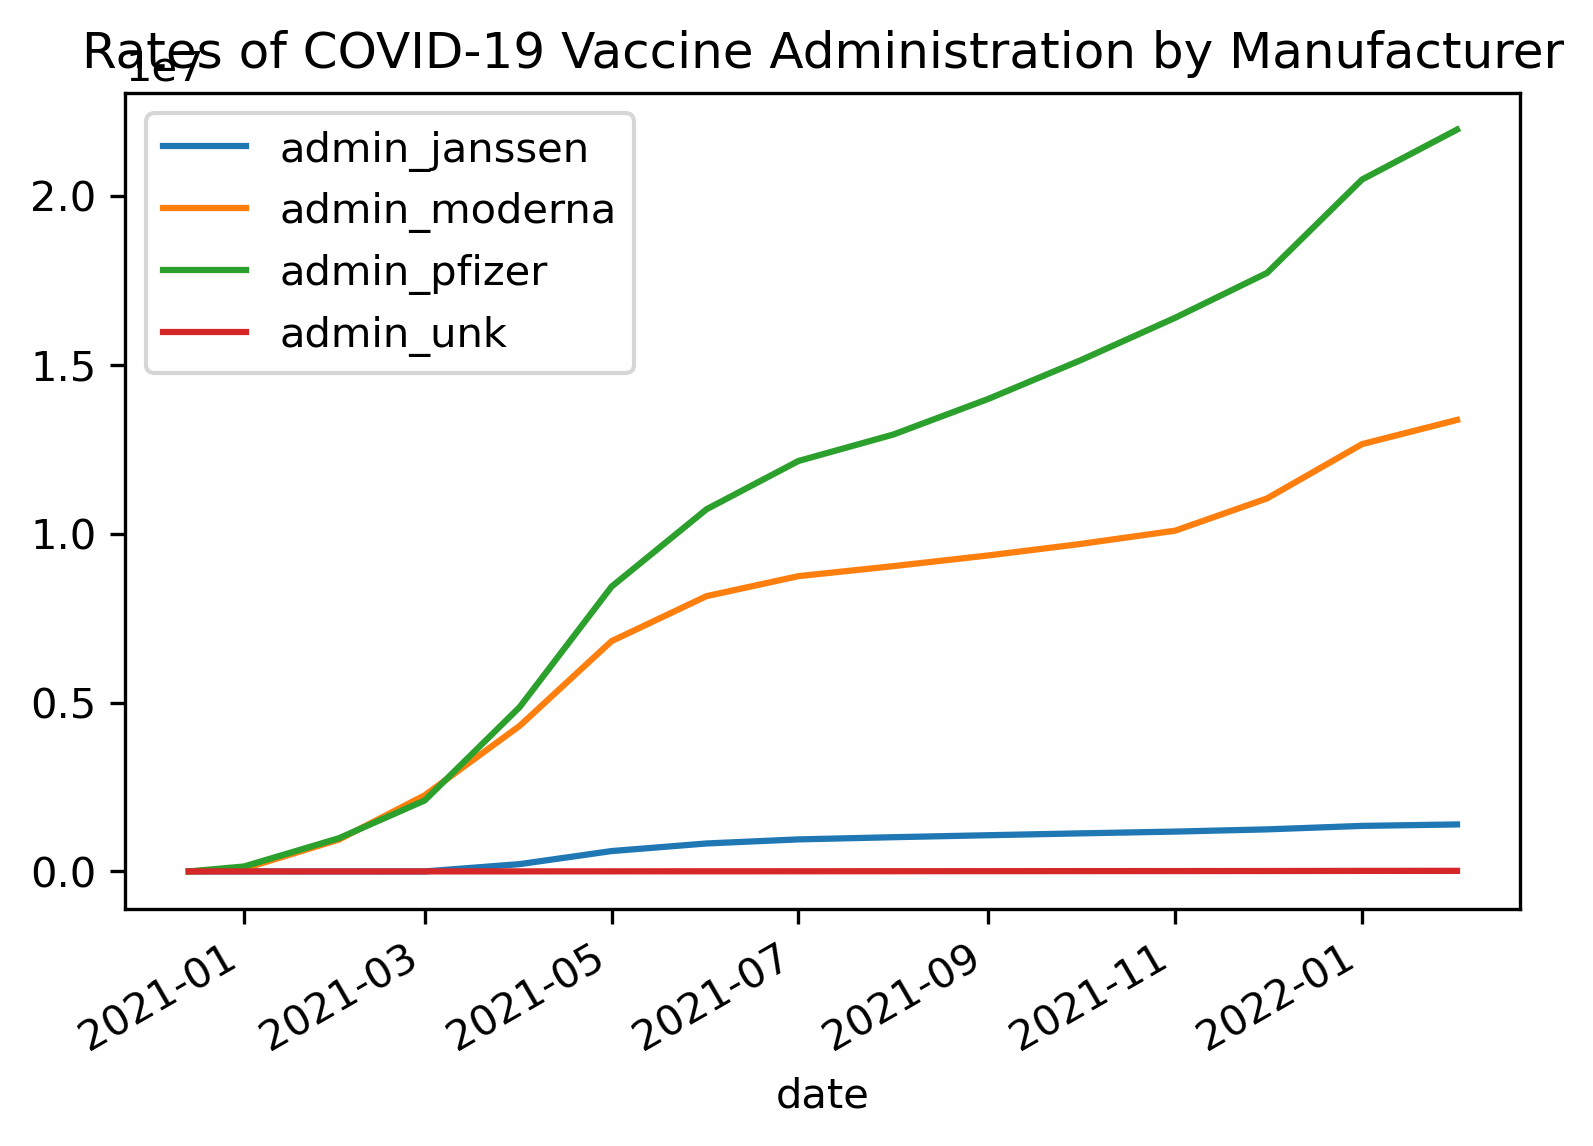

In [25]:
# trend in administration of each vax manufacturer 
ny_m_plt = df_ny_m.reset_index()
ny_m_plt.plot(x="date", y=["admin_janssen", "admin_moderna", "admin_pfizer", "admin_unk"], kind="line", title="Rates of COVID-19 Vaccine Administration by Manufacturer")

In the "Rates of COVID-19 Vaccine Administration by Manufacturer" graph, above, Pfizer and Moderna are the most administered vaccines with Pfizer being the highest. Rates of J&J and vaccines by an unknown manufacturer are very low compared to Pfizer and Moderna. The J&J vaccine has a steady and slow upwards trend as the year progresses.

---

<AxesSubplot:title={'center':'Rate of COVID-19 Vaccine Administration by Age Group'}, xlabel='date'>

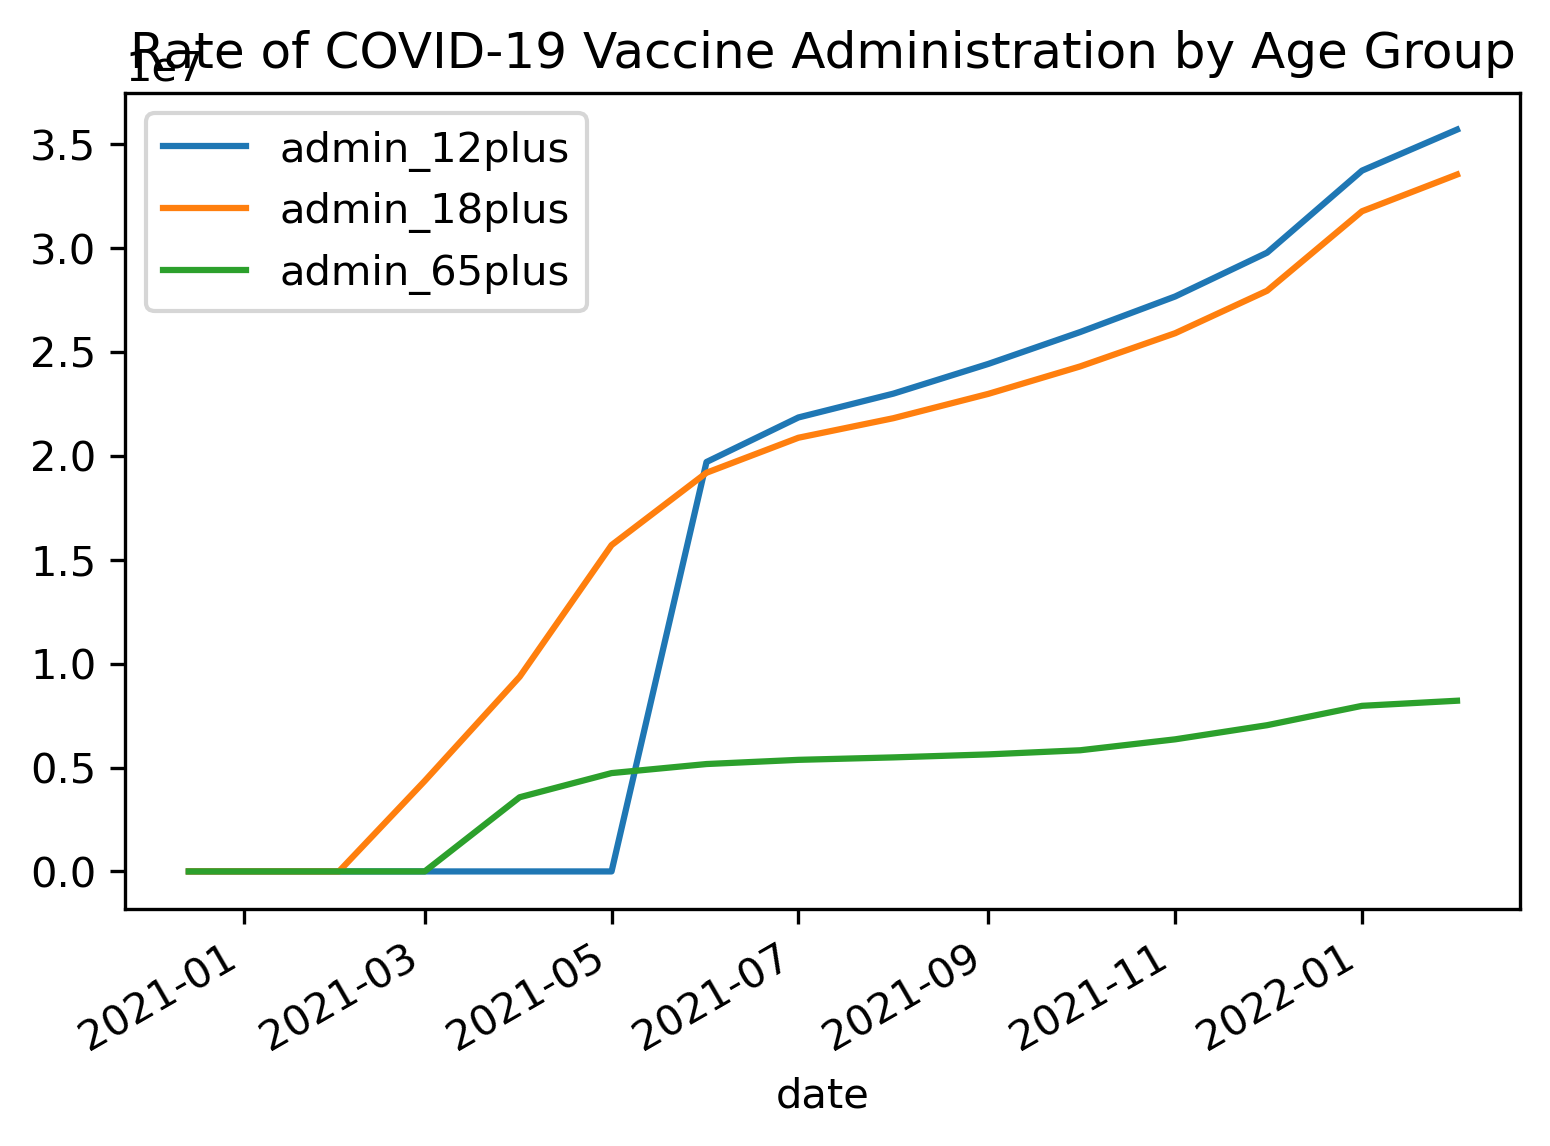

In [26]:
ny_m_plt.plot(x="date", y=["admin_12plus", "admin_18plus", "admin_65plus"], kind="line", title="Rate of COVID-19 Vaccine Administration by Age Group")

In the "Rates of COVID-19 Vaccine Administration by Age Group" graph, above, age group 18plus is the most vaccinated until 12plus spikes in May of 2021 and passes 18plus shortly after. Age group 65plus remains the lowest with a sharp increase in March of 2021 and has been steadily increasing since then. However, this graph only tells part of the story. We should look into the percent of population per each age group to get a better understanding of vaccination trends.

---

<AxesSubplot:title={'center':'Rates of COVID-19 Vaccine Administration by 100k per Age Group'}, xlabel='date'>

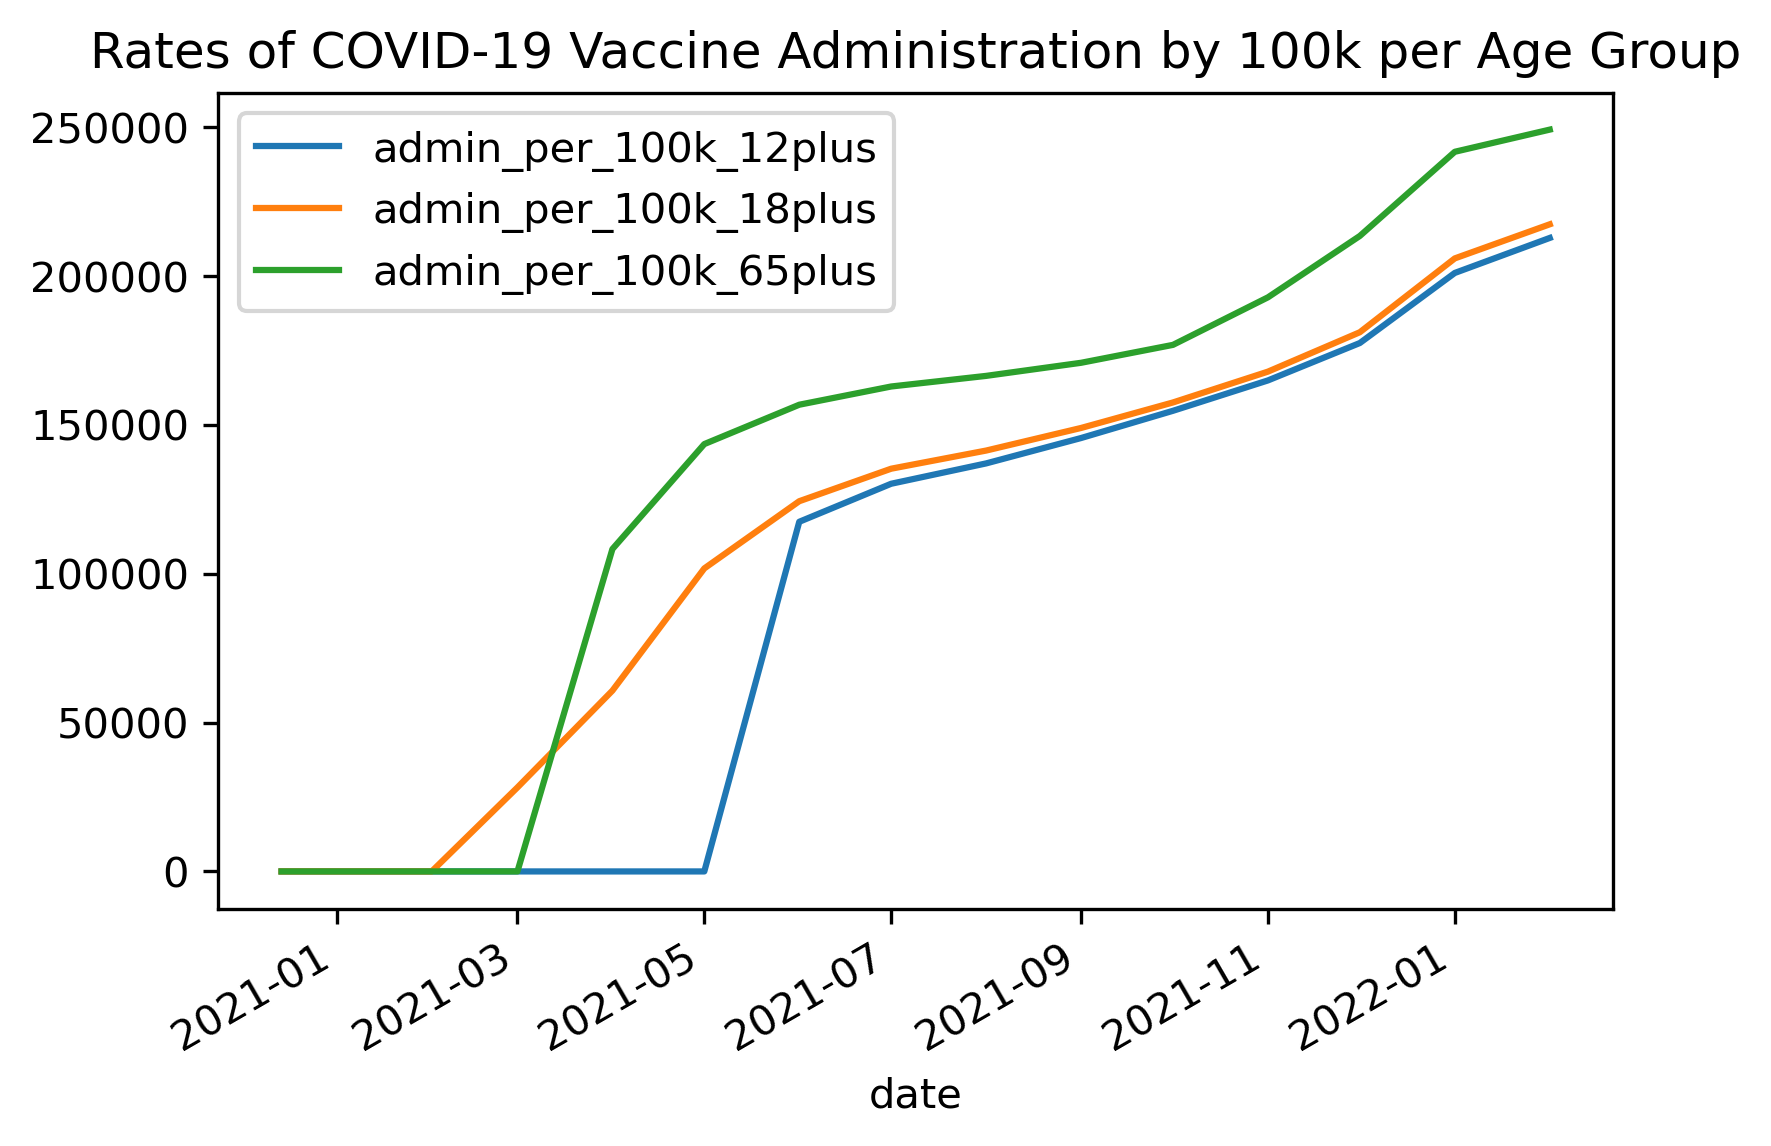

In [27]:
ny_m_plt.plot(x="date", y=["admin_per_100k_12plus", "admin_per_100k_18plus", "admin_per_100k_65plus"], kind="line", title="Rates of COVID-19 Vaccine Administration by 100k per Age Group")


Comparing the "Rates of COVID-19 Vaccine Administration by 100k per Age Group" graph to the graph showing only the value counts for each age group reveals new insights. In the per 100k graph, the 65plus age group remains the highest vaccinated group by a good margin throughout the reported timeframe. Once people 12plus were able to get vaccinated in May 2021 the rate of vaccination for this group rose almost immediately and lies just below the rate of the 18plus group.

---

<AxesSubplot:xlabel='date'>

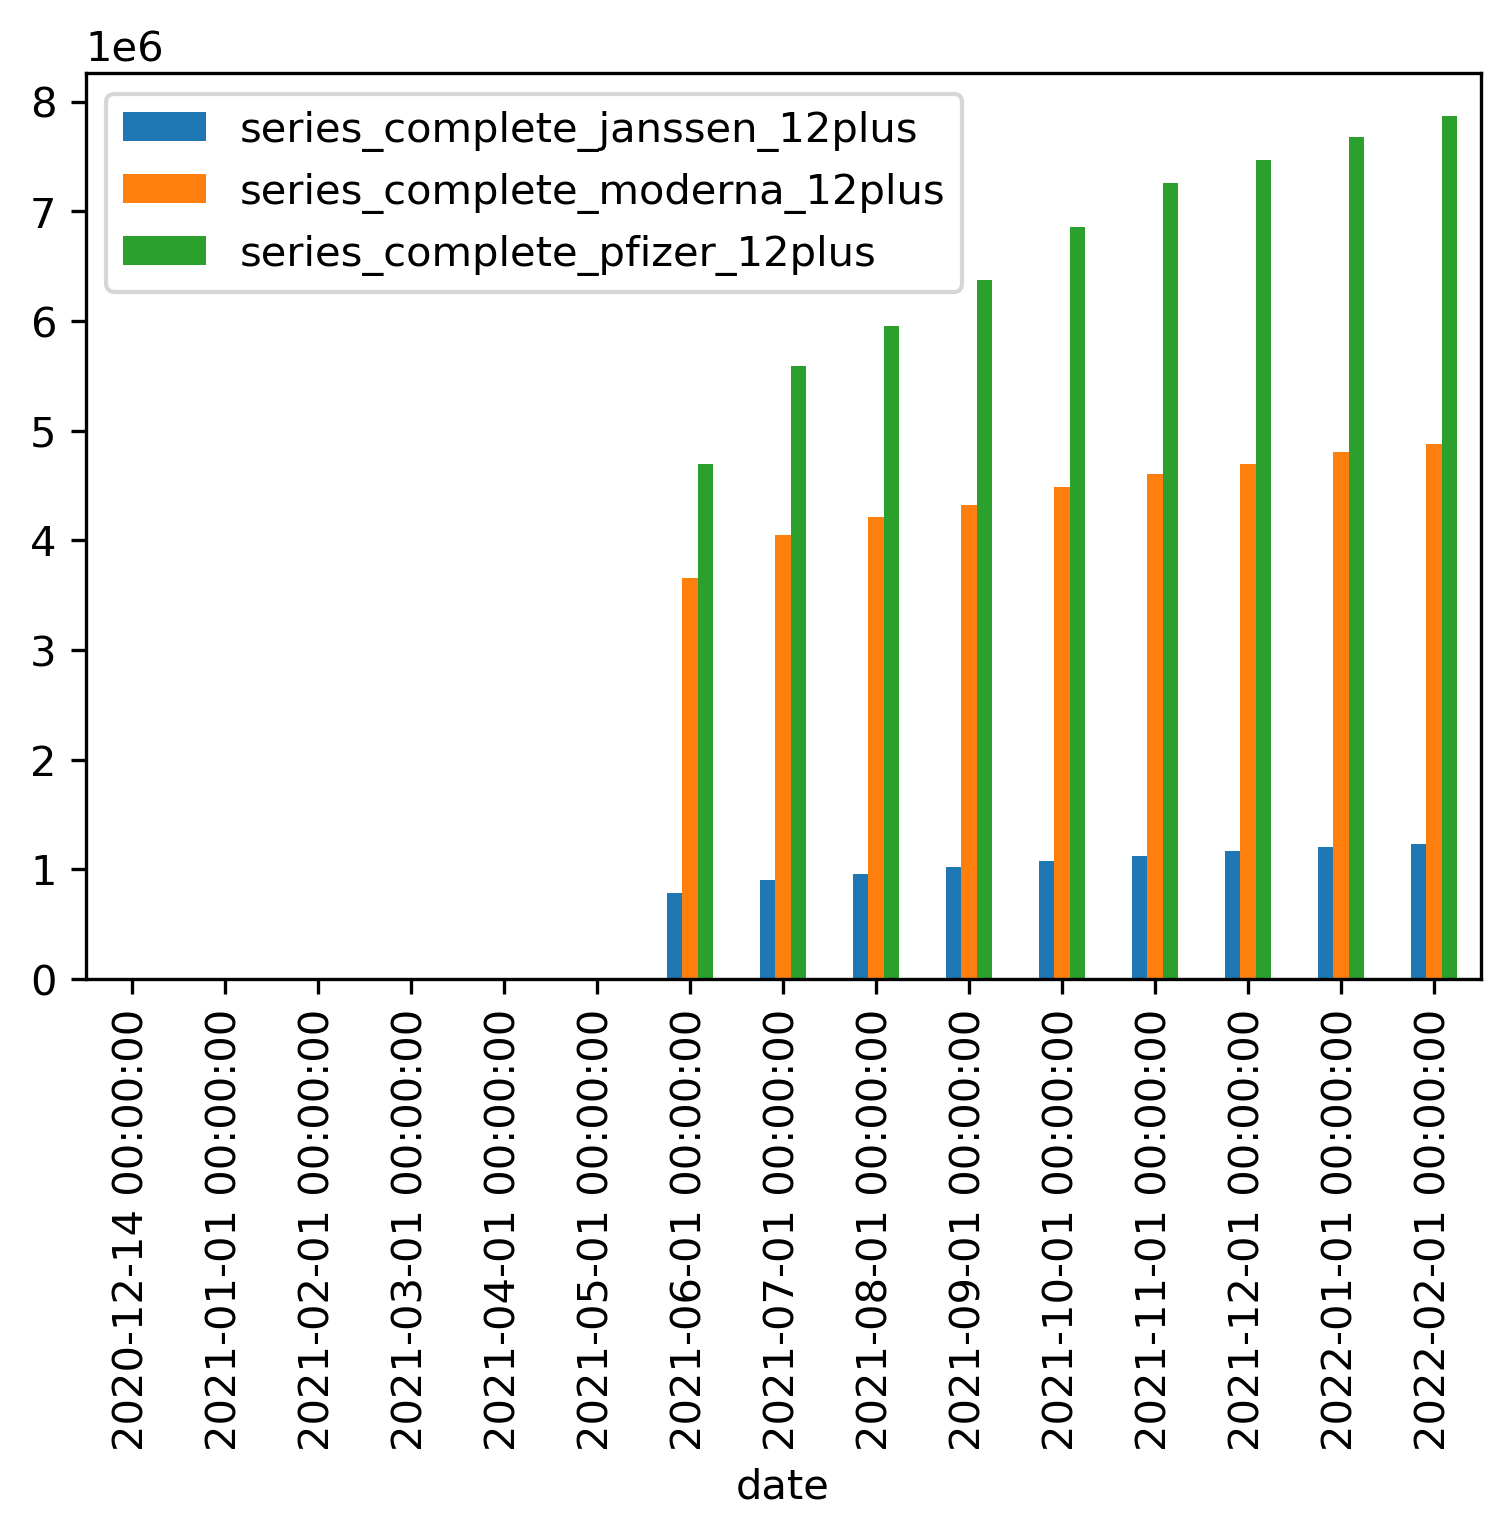

In [28]:
ny_m_plt.plot.bar(x="date", y=['series_complete_janssen_12plus','series_complete_moderna_12plus', 'series_complete_pfizer_12plus'])

In [29]:
df_ny_daily.columns

Index(['admin_12plus', 'admin_18plus', 'admin_65plus', 'admin_janssen',
       'admin_moderna', 'admin_pfizer', 'admin_unk', 'admin_per_100k',
       'admin_per_100k_12plus', 'admin_per_100k_18plus',
       'admin_per_100k_65plus', 'admin_dose1', 'admin_dose1_pop_pct',
       'admin_dose1_12plus', 'admin_dose1_12plus_pop_pct',
       'admin_dose1_18plus', 'admin_dose1_18plus_pop_pct',
       'admin_dose1_65plus', 'admin_dose1_65plus_pop_pct', 'series_complete',
       'series_complete_pop_pct', 'series_complete_12plus',
       'series_complete_12plus_pop_pct', 'series_complete_18plus',
       'series_complete_18plus_pop_pct', 'series_complete_65plus',
       'series_complete_65plus_pop_pct', 'series_complete_janssen',
       'series_complete_moderna', 'series_complete_pfizer',
       'series_complete_unk', 'series_complete_janssen_12plus',
       'series_complete_moderna_12plus', 'series_complete_pfizer_12plus',
       'series_complete_unk_12plus', 'series_complete_janssen_18plus',
   

# covid_cases
Covid cases in NY

In [30]:
# #read data
# covid_df = pd.read_csv("data/covid_cases_4states.csv.zip", compression="zip")
# covid_df.head()

with zipfile.ZipFile("data/covid_cases_4states.csv.zip") as z:
    with z.open("covid_cases_4states.csv") as f:
        covid_df = pd.read_csv(f, low_memory=False)

covid_df.head()
# # open zipped dataset
# with zipfile.ZipFile("test.zip") as z:
#    # open the csv file in the dataset
#    with z.open("test.csv") as f:
       
#       # read the dataset
#       train = pd.read_csv(f)

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2021-10,NY,36,CLINTON,36019.0,65+ years,Female,Missing,NaN,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
1,2021-07,FL,12,BAKER,12003.0,50 to 64 years,Female,NaN,NaN,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN
2,2020-09,NY,36,STEUBEN,36101.0,50 to 64 years,Female,Missing,NaN,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
3,2021-02,FL,12,MANATEE,12081.0,18 to 49 years,Female,Unknown,Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,NaN
4,2021-03,FL,12,MARION,12083.0,50 to 64 years,Female,Unknown,Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,NaN


In [31]:
covid_df.columns #column names

Index(['case_month', 'res_state', 'state_fips_code', 'res_county',
       'county_fips_code', 'age_group', 'sex', 'race', 'ethnicity',
       'case_positive_specimen_interval', 'case_onset_interval', 'process',
       'exposure_yn', 'current_status', 'symptom_status', 'hosp_yn', 'icu_yn',
       'death_yn', 'underlying_conditions_yn'],
      dtype='object')

In [32]:
# covid_df.dtypes

In [33]:
covid_df.shape

(11685325, 19)

In [34]:
#data cleaning
covid_df['case_month'] = pd.to_datetime(covid_df['case_month']) #convert to date

In [35]:
# dropping irrelevant columns
covid_df = covid_df.drop(columns=["case_positive_specimen_interval", "case_onset_interval", "process", "exposure_yn", "current_status"])

In [36]:
# rename cols for readability and uniformify across datasets
covid_rename = {"case_month":"date", "res_state":"state",
               "res_county":"county"}

covid_df = covid_df.rename(columns=covid_rename)

In [37]:
# converting data types 
to_str = ["state", "county", "age_group", "sex", "race", "ethnicity",
          "symptom_status", "hosp_yn", "icu_yn", "death_yn", "underlying_conditions_yn"]
covid_df[to_str] = covid_df[to_str].astype(str)

In [38]:
# show cols with NaNs
covid_df.columns[covid_df.isnull().any()]

Index(['county_fips_code'], dtype='object')

In [39]:
# fill NaNs in county_fips_code with "Not Available"
covid_df["county_fips_code"] = covid_df["county_fips_code"].fillna("Not Available")

# shows all values within the race col
covid_df.race.unique()

# rename nan, Missing, and Unknown to Not Available
rename_covid_nan = {"nan":"Not Available",
                     "Missing":"Not Available",
                     "Unknown":"Not Available"}
covid_df["race"] = covid_df["race"].replace(rename_covid_nan).astype(str)

# same treatment for ethnicity as the race col
covid_df.ethnicity.unique()

covid_df["ethnicity"] = covid_df["ethnicity"].replace(rename_covid_nan).astype(str)

covid_df["county"] = covid_df["county"].replace({"nan":"Not Available"})

# checking for NaN string values and replace with "Not Available" in remaining cols
covid_df.age_group.unique()
covid_df["age_group"] = covid_df["age_group"].replace({"nan":"Not Available", "Missing":"Not Available"}).astype(str)

covid_df["sex"] = covid_df["sex"].replace(rename_covid_nan).astype(str)

covid_df["death_yn"] = covid_df["death_yn"].replace(rename_covid_nan).astype(str)

covid_df["underlying_conditions_yn"] = covid_df["underlying_conditions_yn"].replace(rename_covid_nan).astype(str)

rename_missing_unk = {"Missing":"Not Available",
                      "Unknown":"Not Available"}
rename_col = ["symptom_status", "hosp_yn", "icu_yn"]
covid_df[rename_col] = covid_df[rename_col].replace(rename_missing_unk).astype(str)

In [40]:
covid_df.sample(10, random_state = 42)

,date,state,state_fips_code,county,county_fips_code,age_group,sex,race,ethnicity,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
11639060,2021-12-01,TX,48,Not Available,Not Available,18 to 49 years,Male,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available
7365273,2021-01-01,CA,6,KERN,6029.0,18 to 49 years,Female,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available
2826409,2020-05-01,CA,6,MONTEREY,6053.0,18 to 49 years,Male,White,Hispanic/Latino,Symptomatic,No,Not Available,Not Available,Not Available
3894756,2021-08-01,NY,36,ORANGE,36071.0,18 to 49 years,Female,Not Available,Hispanic/Latino,Symptomatic,No,Not Available,No,Not Available
8602615,2021-08-01,NY,36,SUFFOLK,36103.0,65+ years,Male,Not Available,Not Available,Not Available,Not Available,Not Available,No,Not Available
10347080,2021-09-01,FL,12,MIAMI-DADE,12086.0,65+ years,Female,White,Hispanic/Latino,Not Available,No,Not Available,No,Not Available
5423655,2021-09-01,NY,36,MONROE,36055.0,0 - 17 years,Female,Black,Non-Hispanic/Latino,Not Available,Not Available,Not Available,No,Not Available
5897489,2020-12-01,CA,6,ALAMEDA,6001.0,18 to 49 years,Male,Multiple/Other,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available
9556751,2021-01-01,NY,36,QUEENS,36081.0,18 to 49 years,Female,White,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available
1140622,2021-09-01,NY,36,CHAUTAUQUA,36013.0,18 to 49 years,Female,Not Available,Not Available,Not Available,Not Available,Not Available,No,Not Available


In [41]:
covid_df.describe(include = 'all',datetime_is_numeric=True) #describe and include string columns

,date,state,state_fips_code,county,county_fips_code,age_group,sex,race,ethnicity,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
count,11685325,11685325,1.168532e+07,11685325,11685325.0,11685325,11685325,11685325,11685325,11685325,11685325,11685325,11685325,11685325
unique,NaN,4,NaN,183,193.0,5,3,7,3,3,3,3,3,3
top,NaN,CA,NaN,LOS ANGELES,6037.0,18 to 49 years,Female,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available
freq,NaN,5432976,NaN,1642860,1642860.0,6360491,5939350,5112583,5464654,6744391,6117797,11532405,8564638,11270556
mean,2021-02-15 09:40:04.885615872,NaN,1.668762e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2020-01-01 00:00:00,NaN,6.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2020-11-01 00:00:00,NaN,6.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2021-01-01 00:00:00,NaN,1.200000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2021-08-01 00:00:00,NaN,3.600000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2021-12-01 00:00:00,NaN,4.800000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


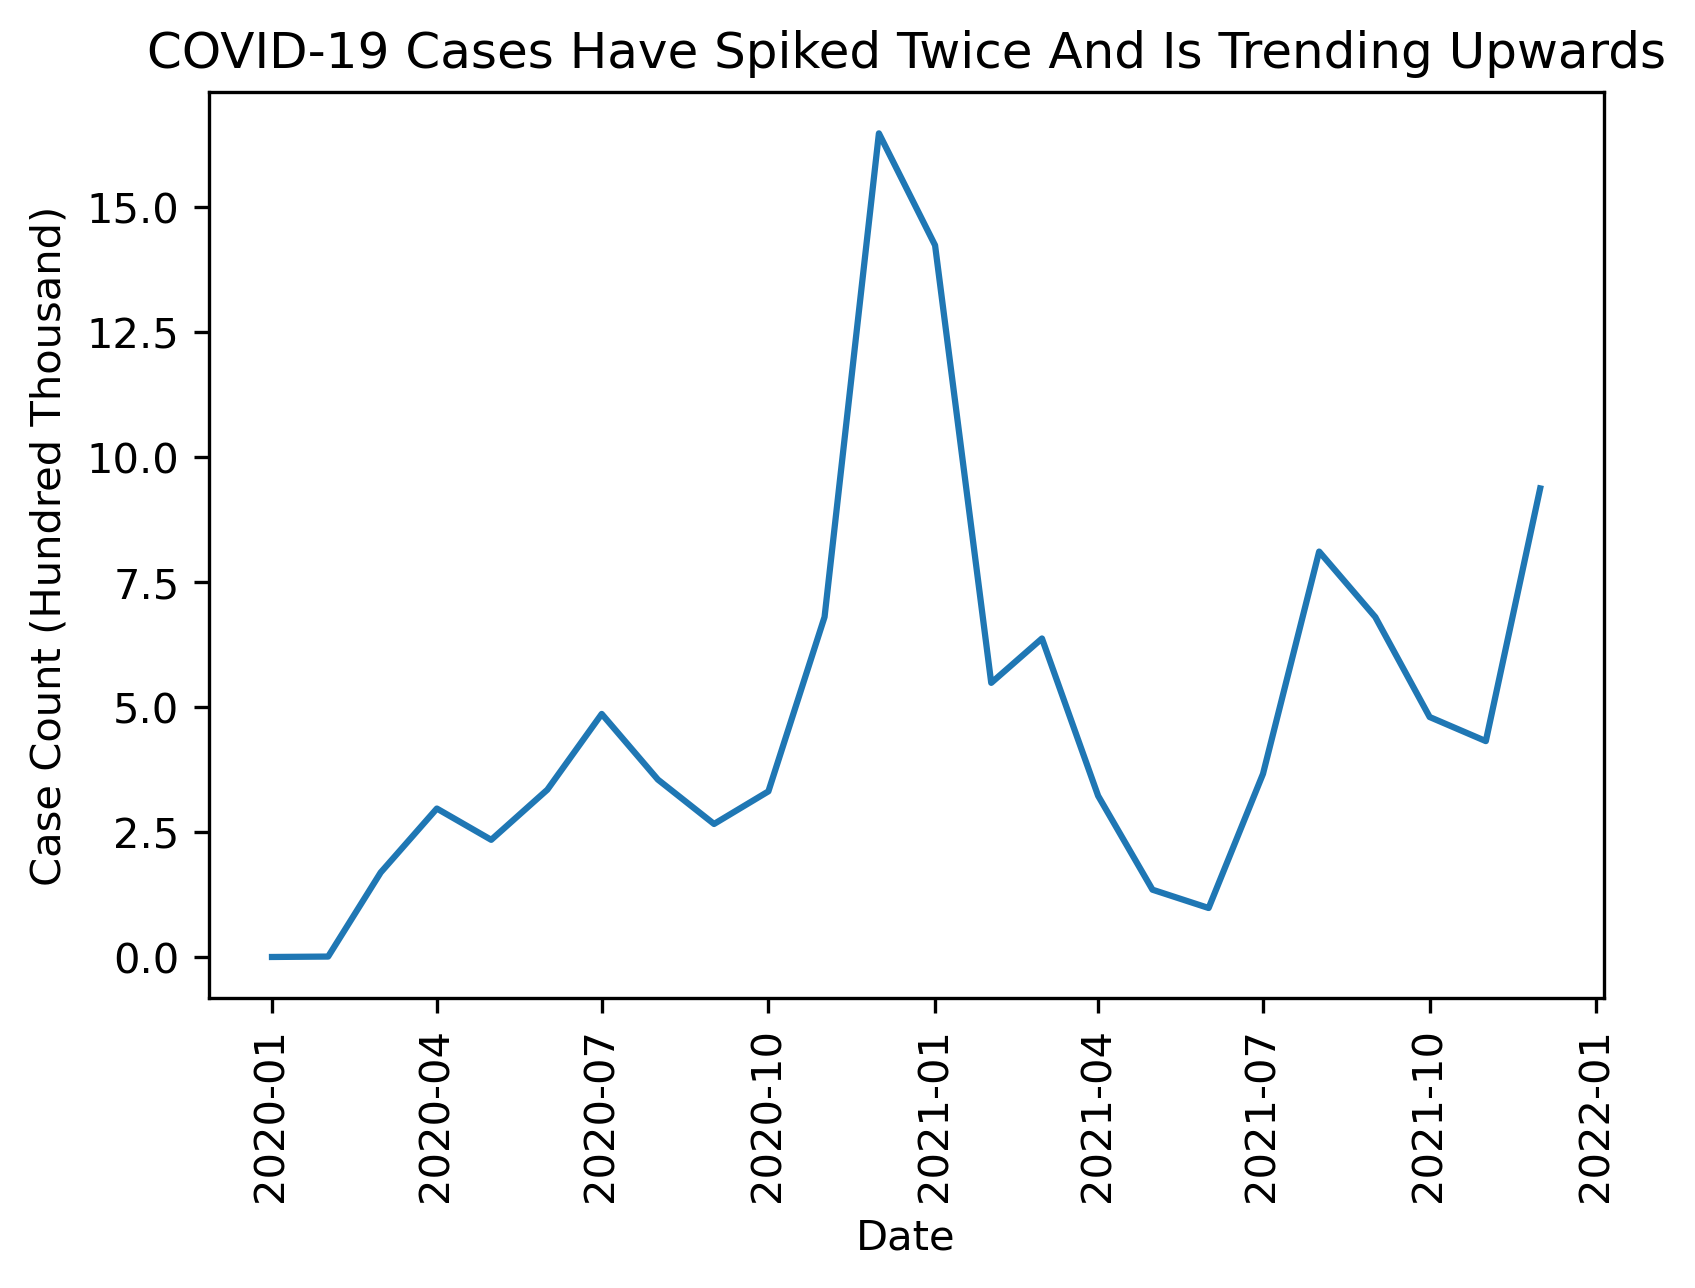

In [42]:
#covid cases trend
trend_df = covid_df.groupby(['date']).size().reset_index(name = 'case_count').set_index('date')
trend_df['case_count_per_100k'] = trend_df['case_count']/100000
plt.plot(trend_df.index,trend_df['case_count_per_100k'])
plt.title('COVID-19 Cases Have Spiked Twice And Is Trending Upwards')
plt.xlabel('Date')
plt.ylabel('Case Count (Hundred Thousand)')
plt.xticks(rotation=90)
plt.show()

In [52]:
trend_df

,case_count,case_count_per_100k
date,,
2020-01-01,998,0.00998
2020-02-01,1854,0.01854
2020-03-01,169876,1.69876
2020-04-01,297641,2.97641
2020-05-01,235140,2.35140
2020-06-01,335342,3.35342
2020-07-01,486703,4.86703
2020-08-01,355542,3.55542
2020-09-01,266833,2.66833


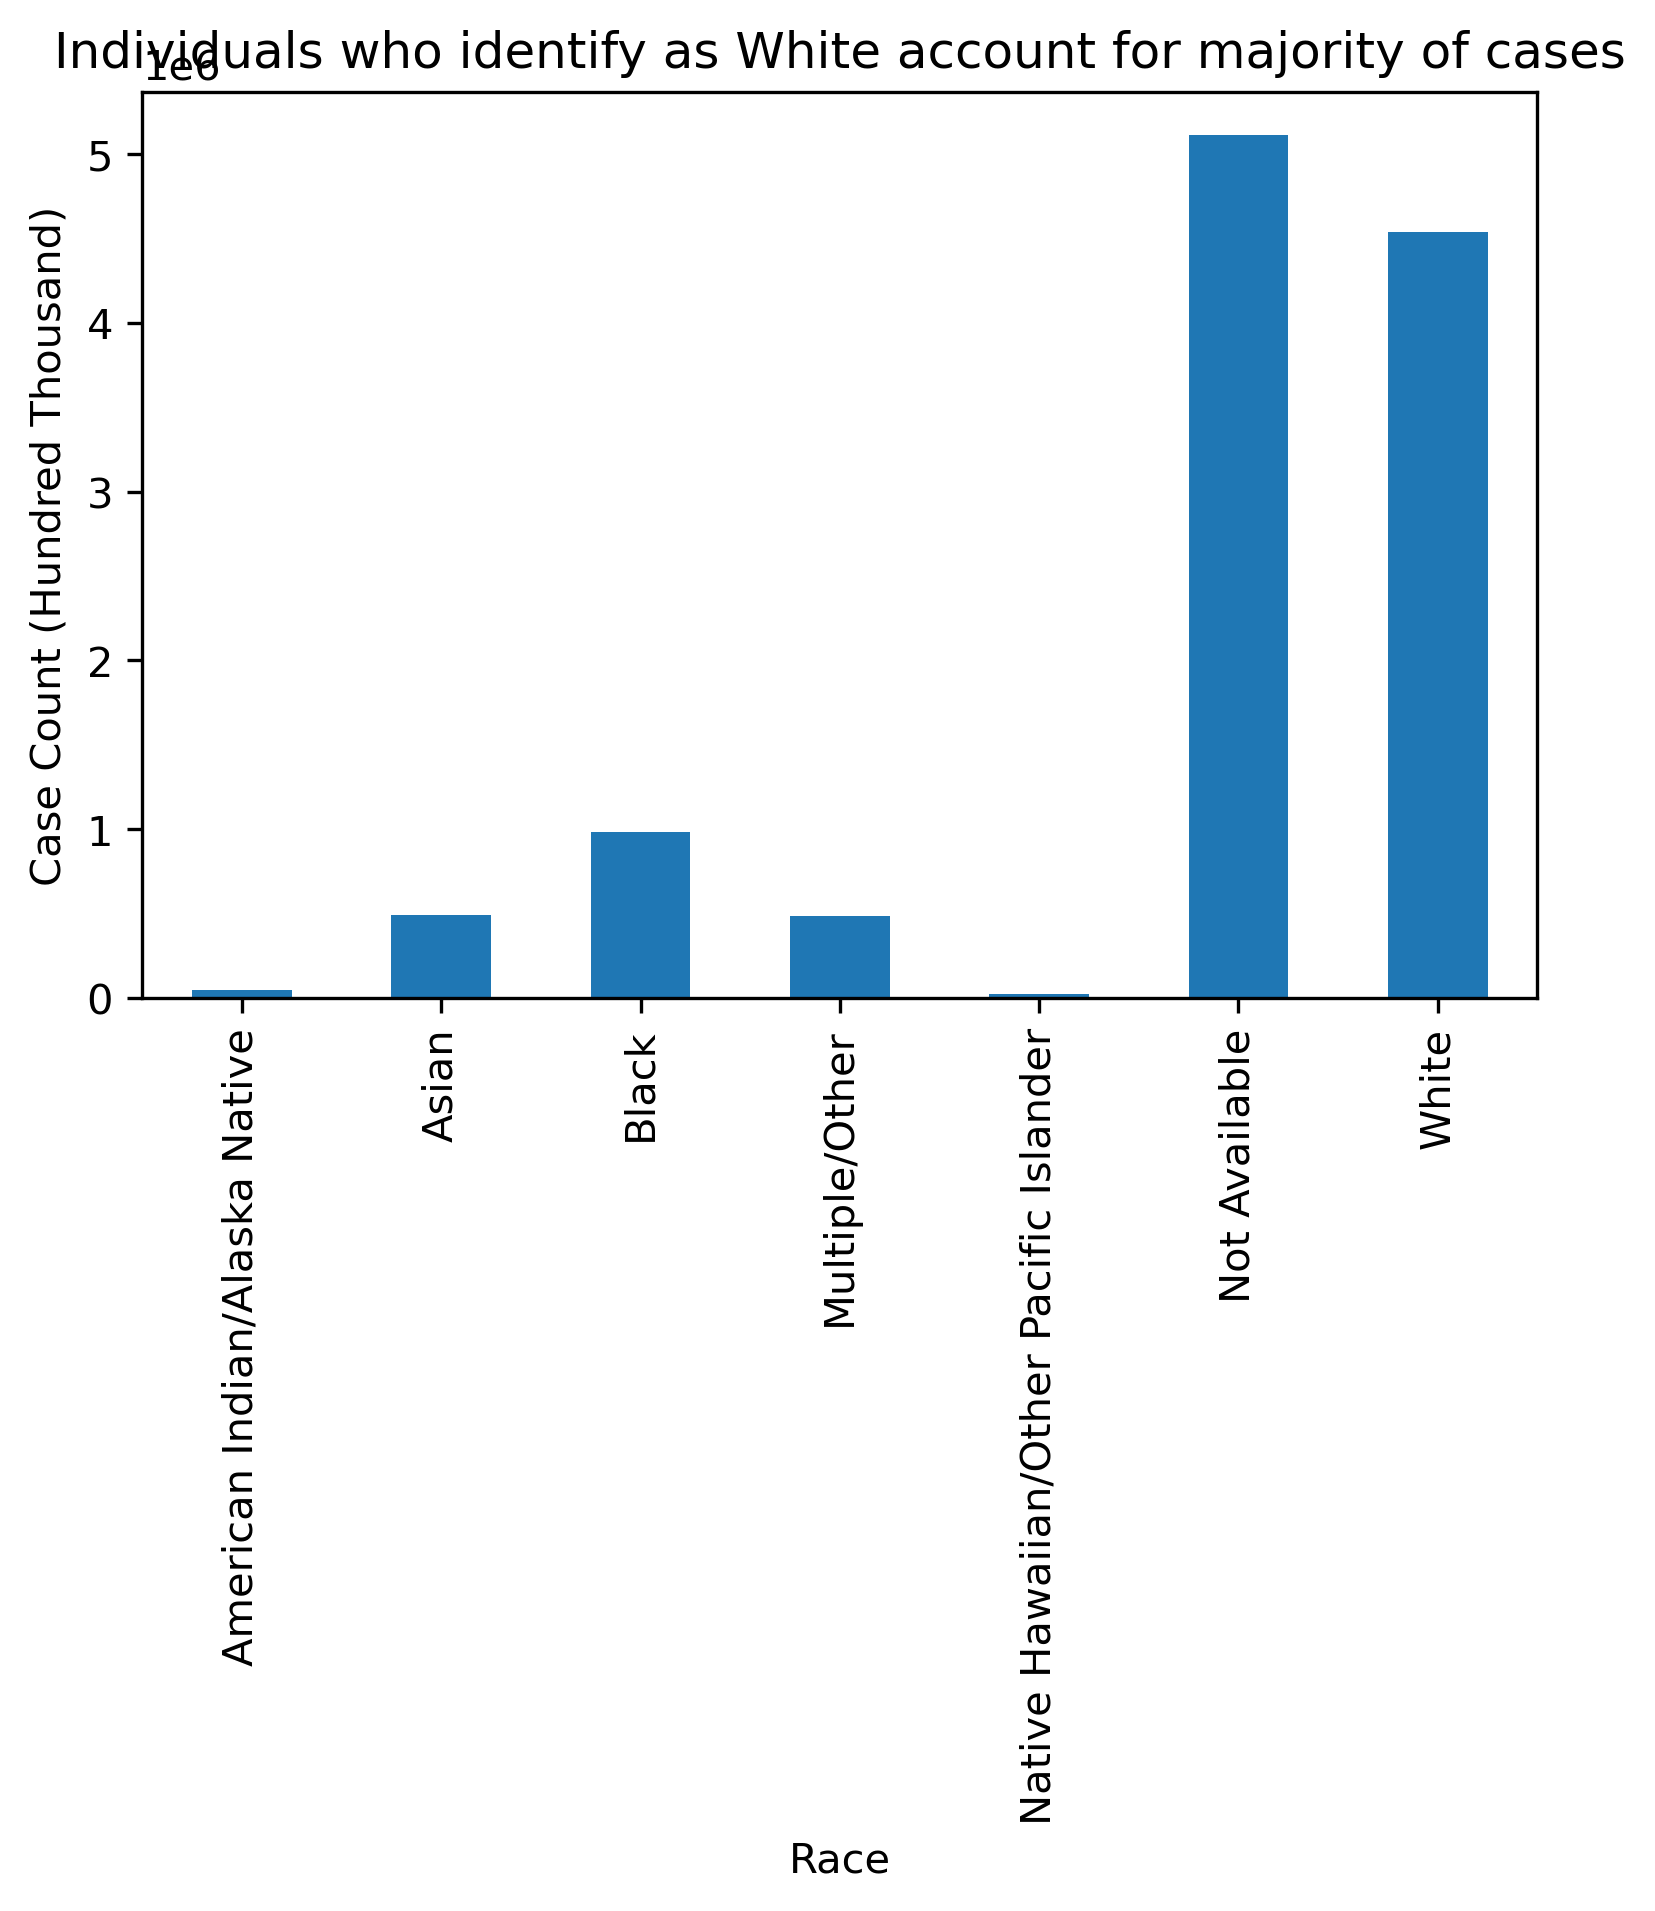

In [44]:
covid_df.groupby(['race']).size().plot.bar()
plt.title('Individuals who identify as White account for majority of cases')
plt.xlabel('Race')
plt.ylabel('Case Count (Hundred Thousand)')
plt.xticks(rotation=90)
plt.show()

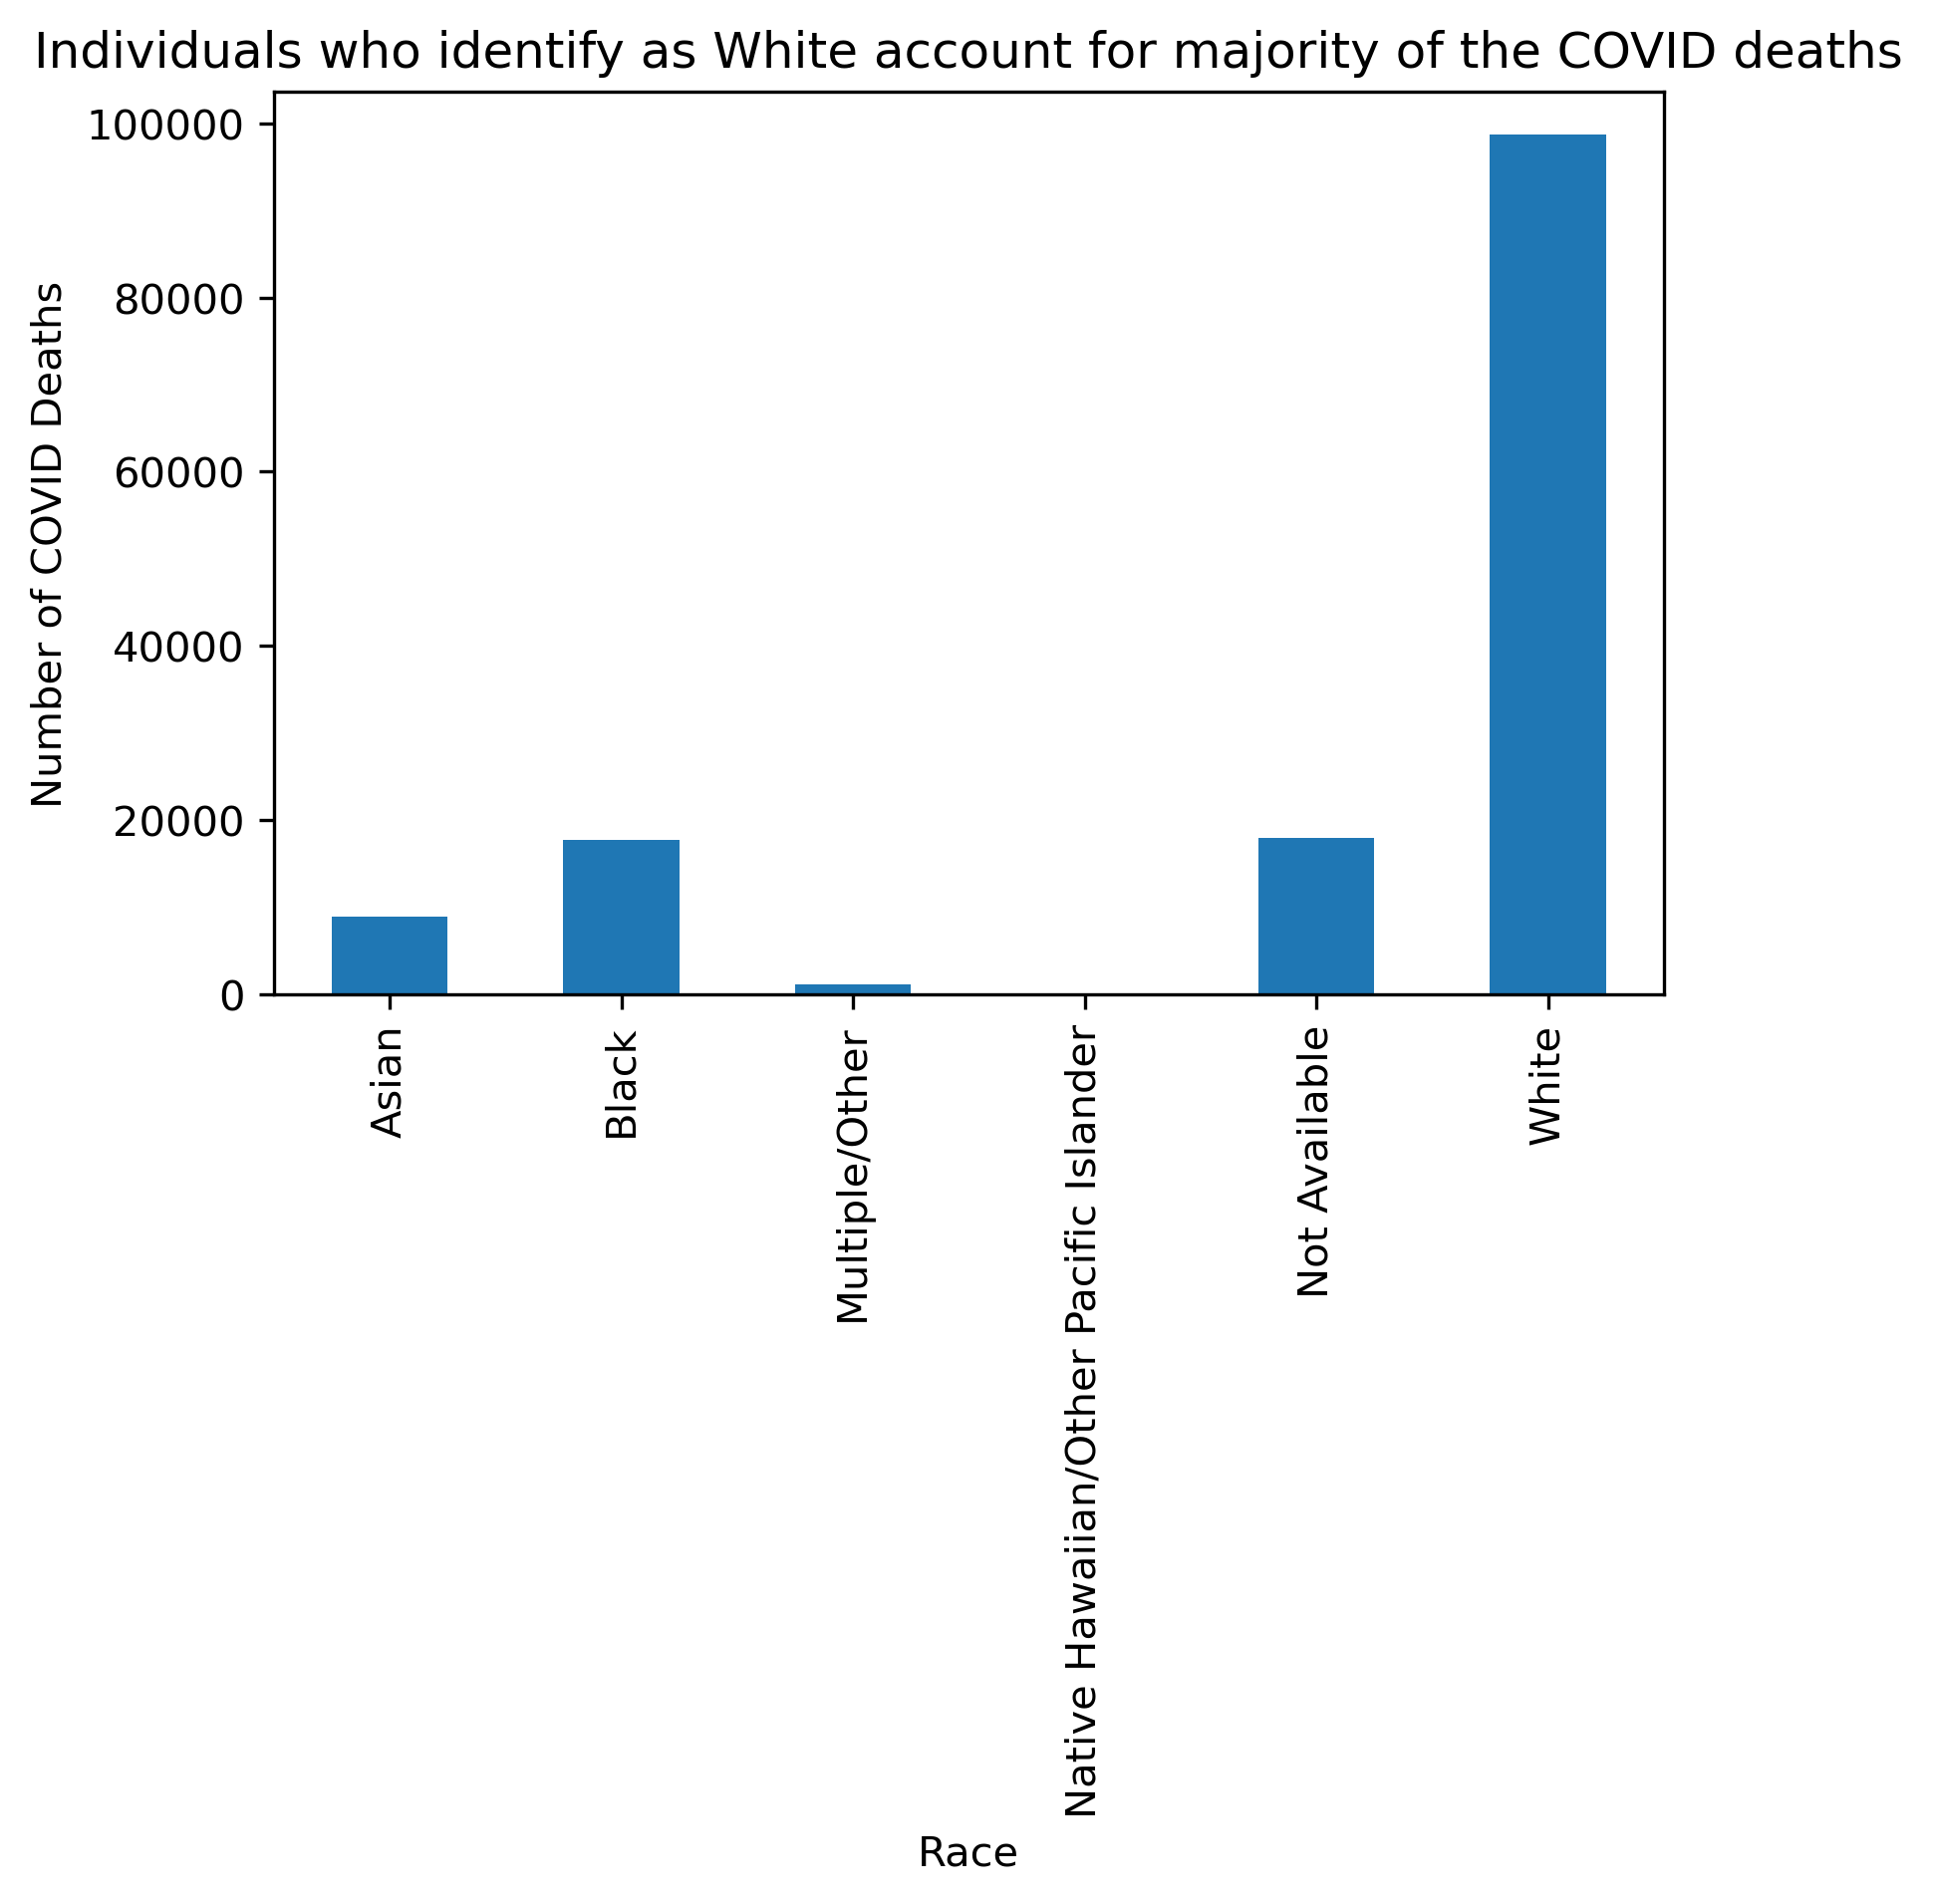

In [45]:
#death status per race
death_df = covid_df[covid_df['death_yn'] == 'Yes'] 
death_df.groupby(['race']).size().plot.bar()
plt.title('Individuals who identify as White account for majority of the COVID deaths')
plt.xlabel('Race')
plt.ylabel('Number of COVID Deaths')
plt.xticks(rotation=90)
plt.show()

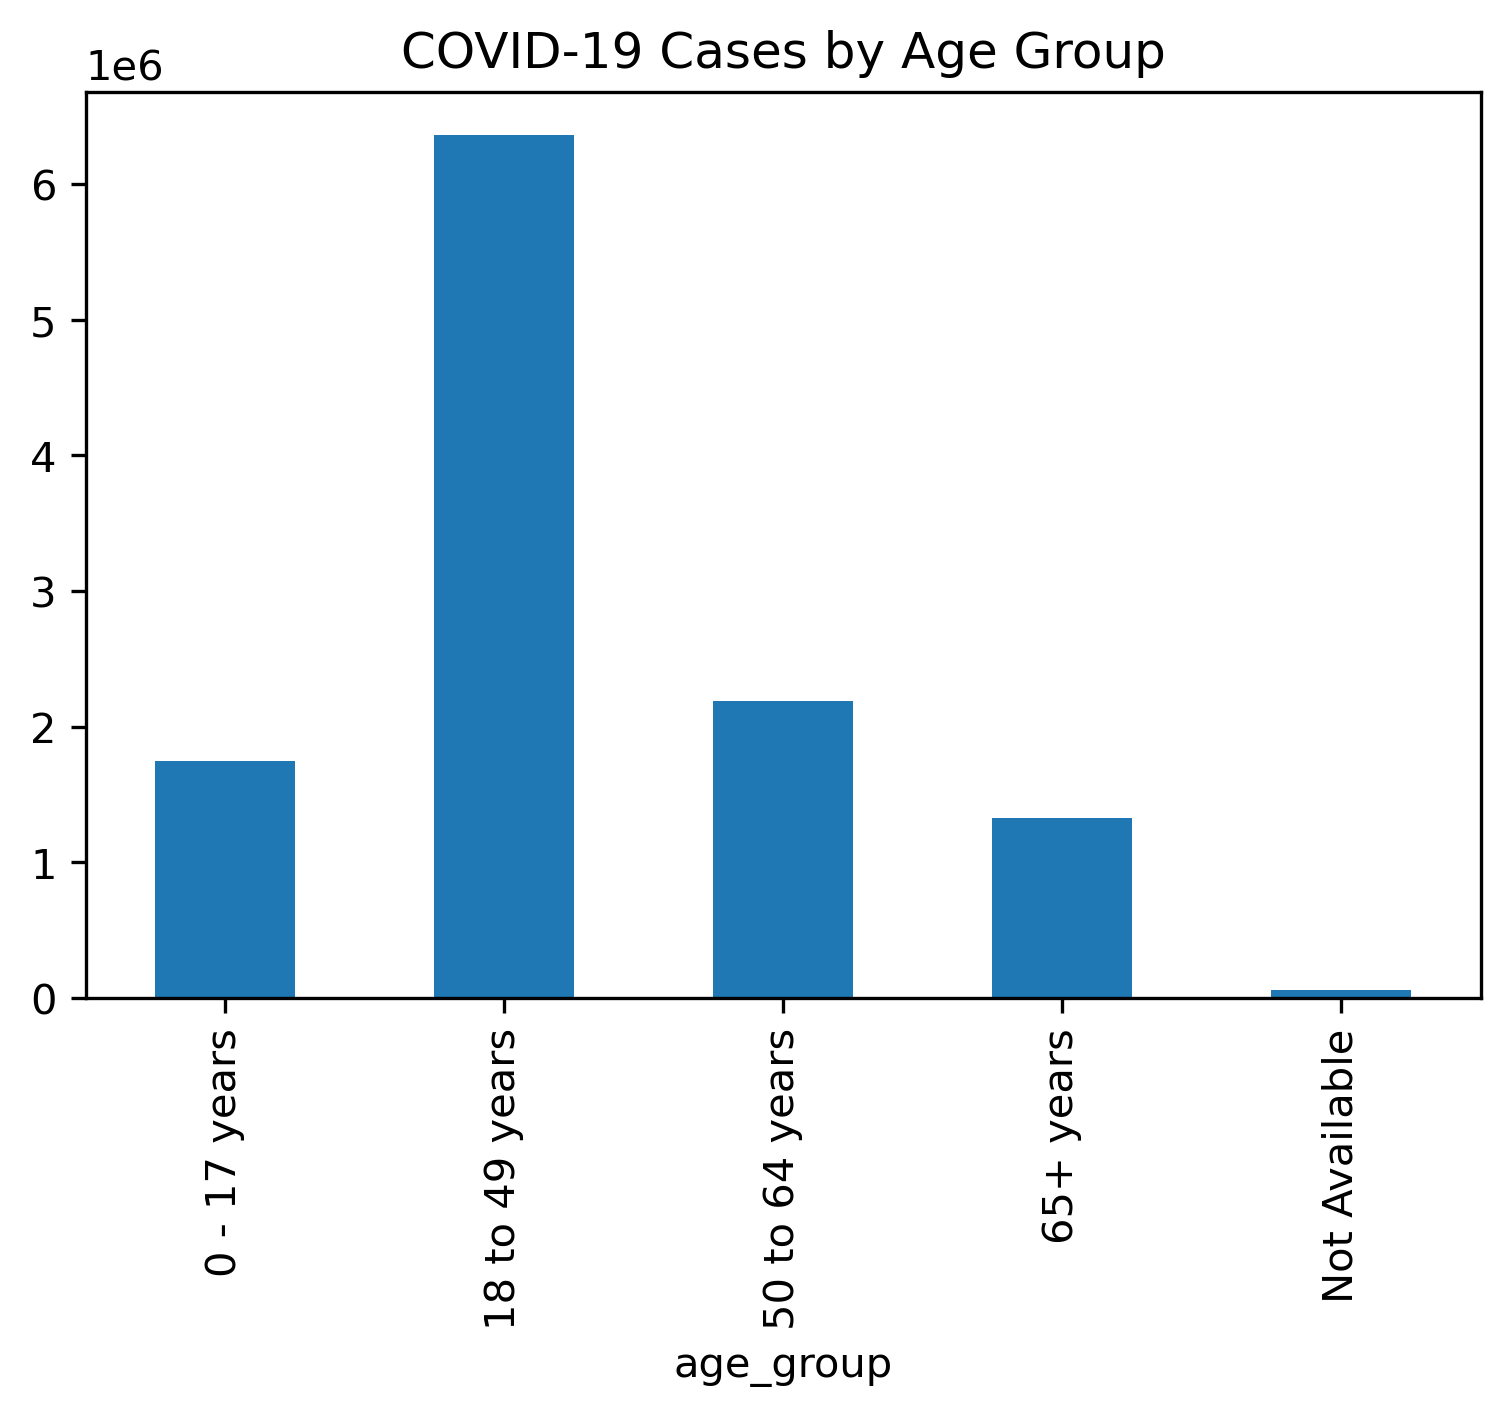

In [46]:
covid_df.groupby(["age_group"]).size().plot.bar()
plt.title("COVID-19 Cases by Age Group");

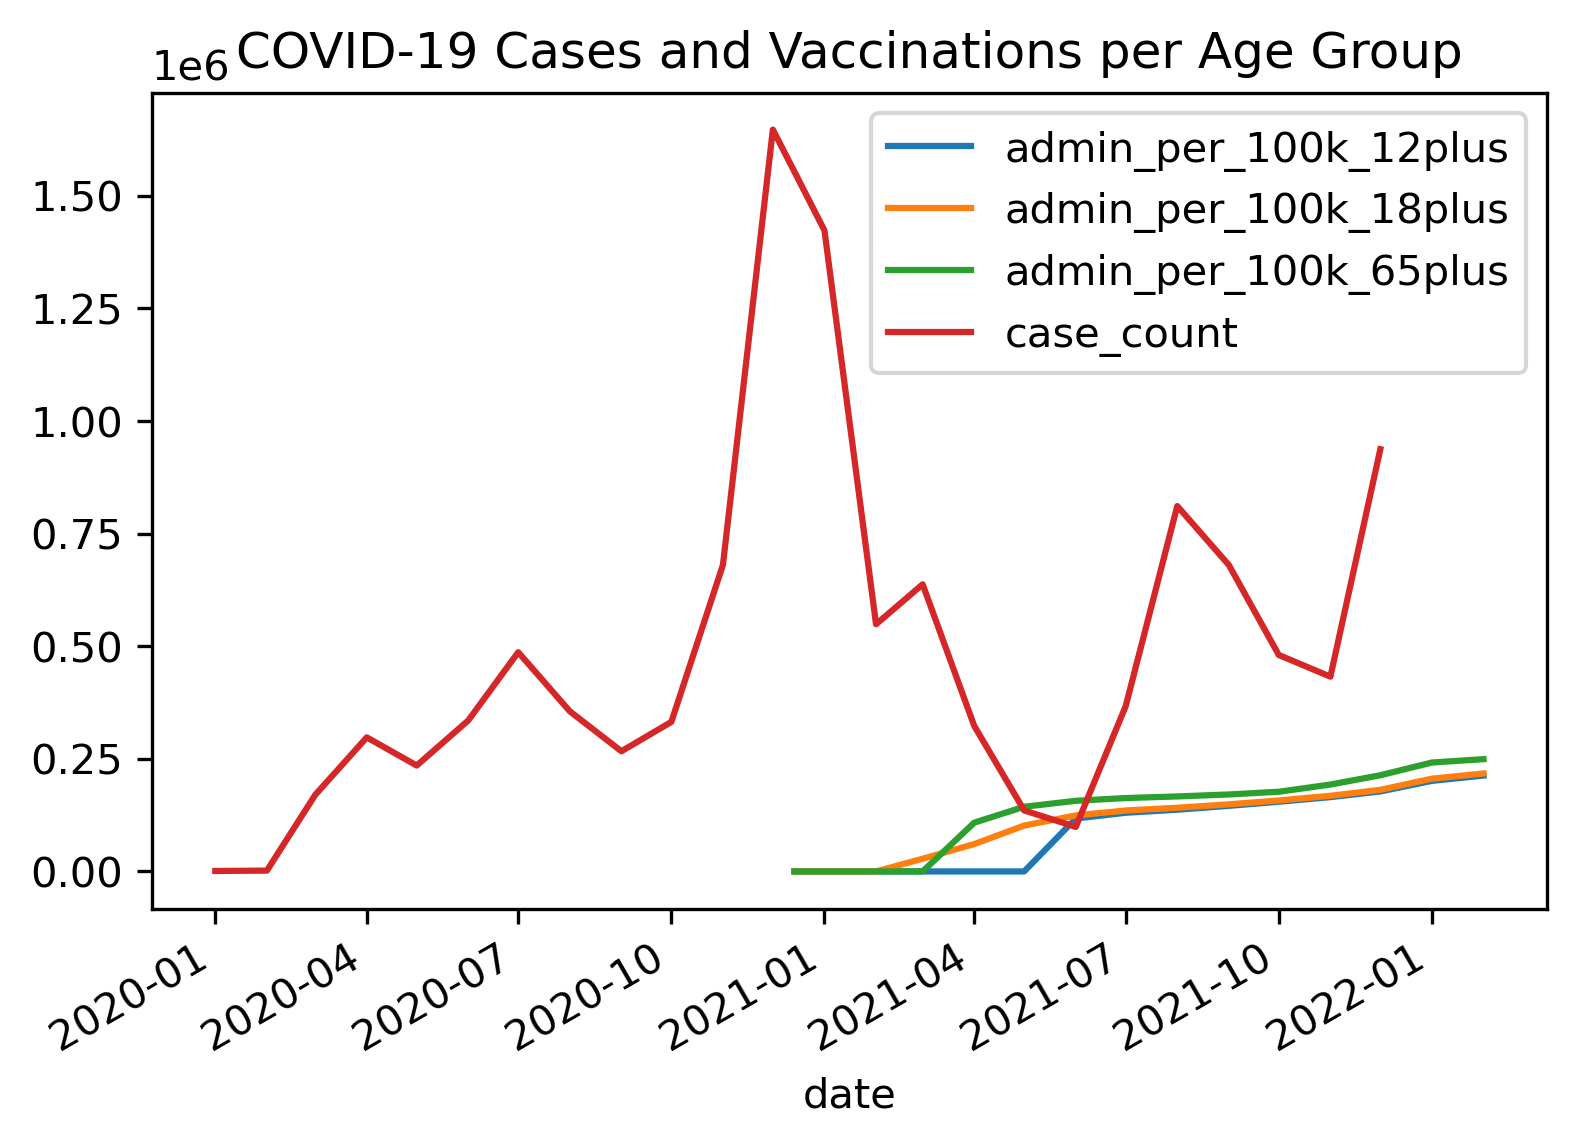

In [47]:
# comparing cases with vaccine administration rates
case_vax_ax = ny_m_plt.plot(x="date", y=["admin_per_100k_12plus", "admin_per_100k_18plus", "admin_per_100k_65plus"], kind="line")
trend_df.plot(y="case_count", kind="line", ax=case_vax_ax, title="COVID-19 Cases and Vaccinations per Age Group");                            

When comparing the COVID case trends with the trends in vaccine administration across each age group, it can be seen that the number of cases starts to sharply decline as the population recieves the vaccine. The case_count trend line was already falling when the vaccines were made available. However, once more of the population started to get vaccinated the case numbers stayed low up until the omicron variant began spreading around November of 2021 up until now (mid-January 2022).

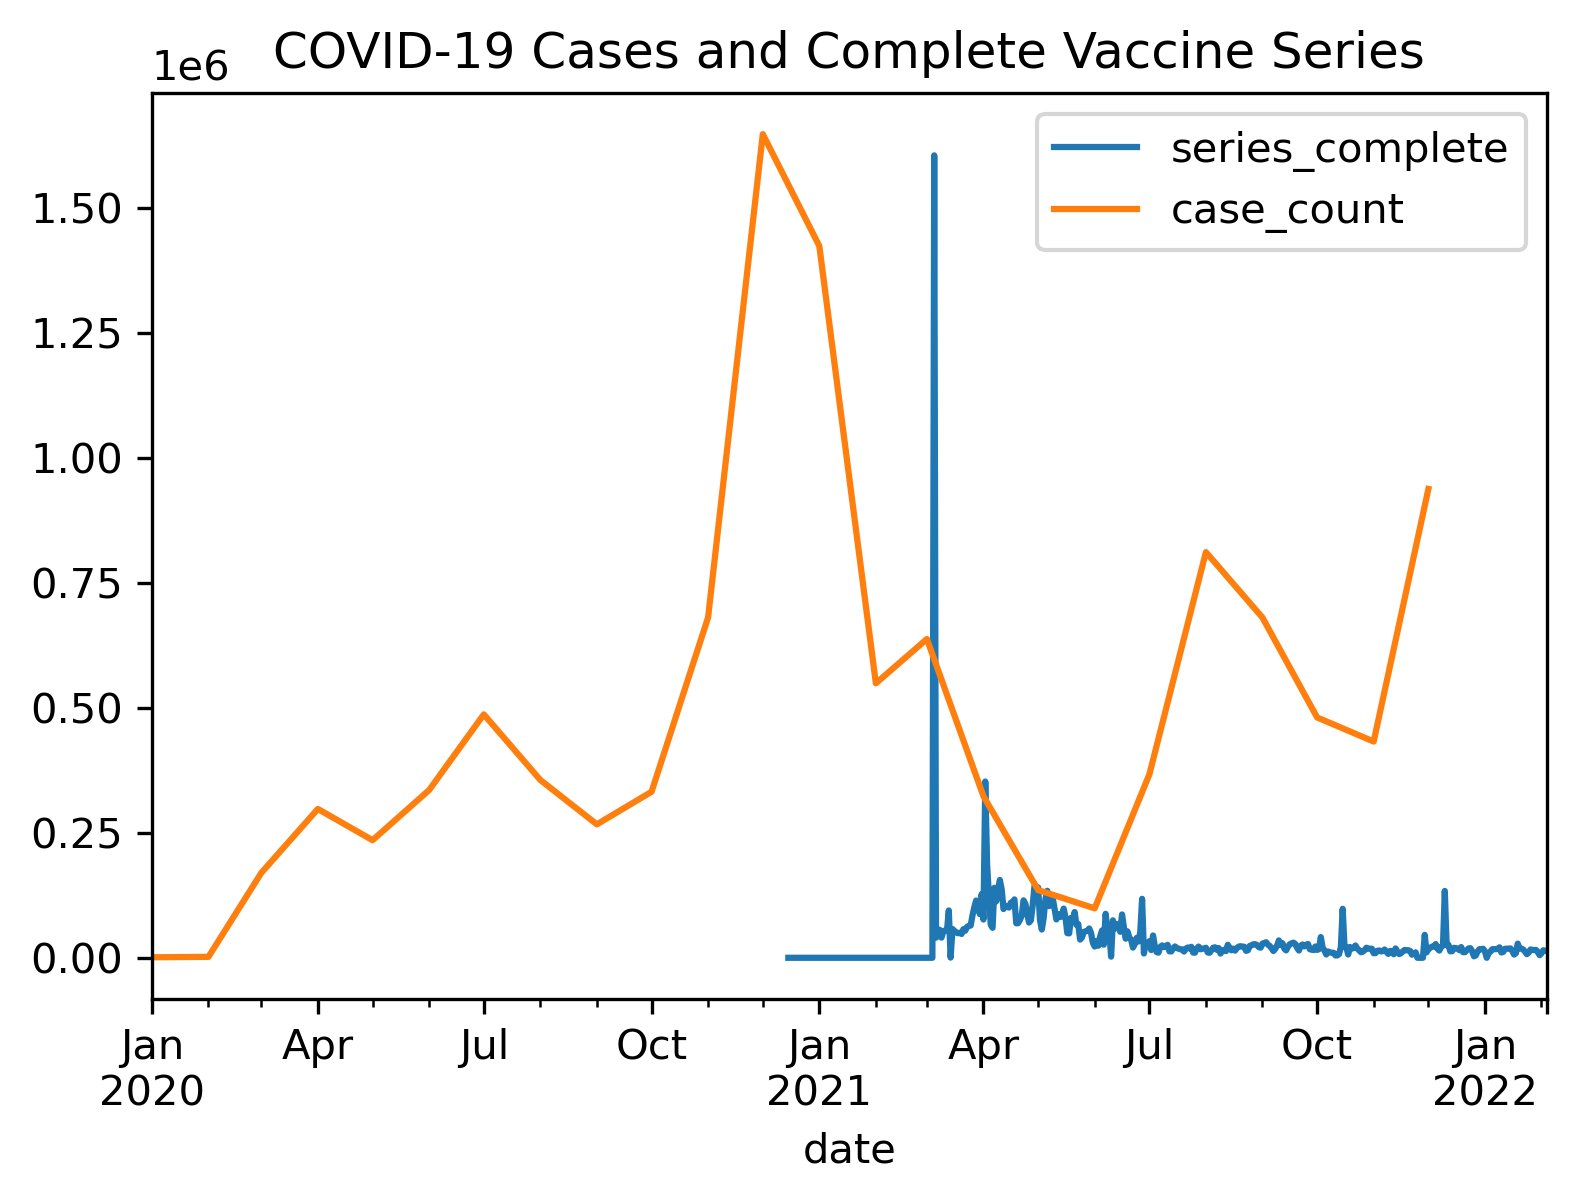

In [48]:
case_comp_ax = daily_plt.plot(x="date", y='series_complete', kind="line")
trend_df.plot(y="case_count", kind="line", ax=case_comp_ax, title="COVID-19 Cases and Complete Vaccine Series");

In [49]:
covid_65plus = covid_df.loc[covid_df["age_group"] == "65+ years"]


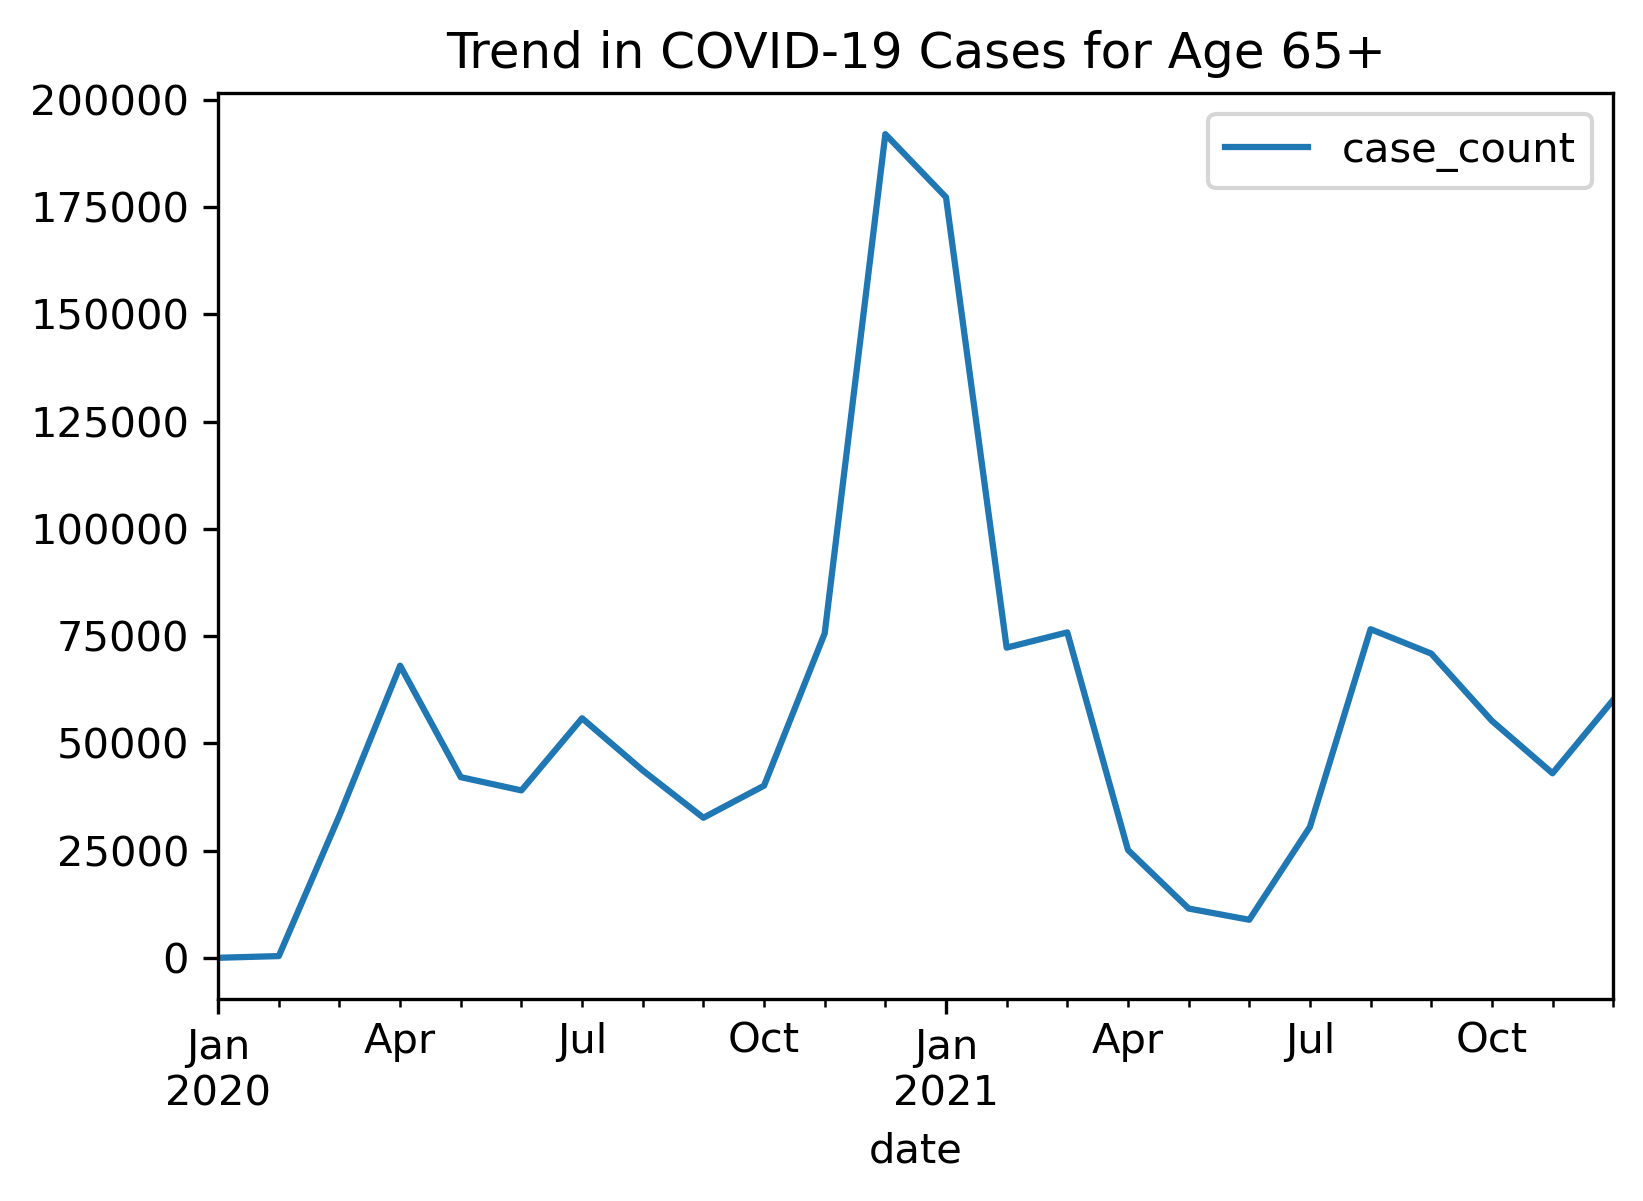

In [50]:
df_covid65 = covid_65plus.groupby(['date']).size().reset_index(name = 'case_count').set_index('date')

df_covid65.plot(title="Trend in COVID-19 Cases for Age 65+");

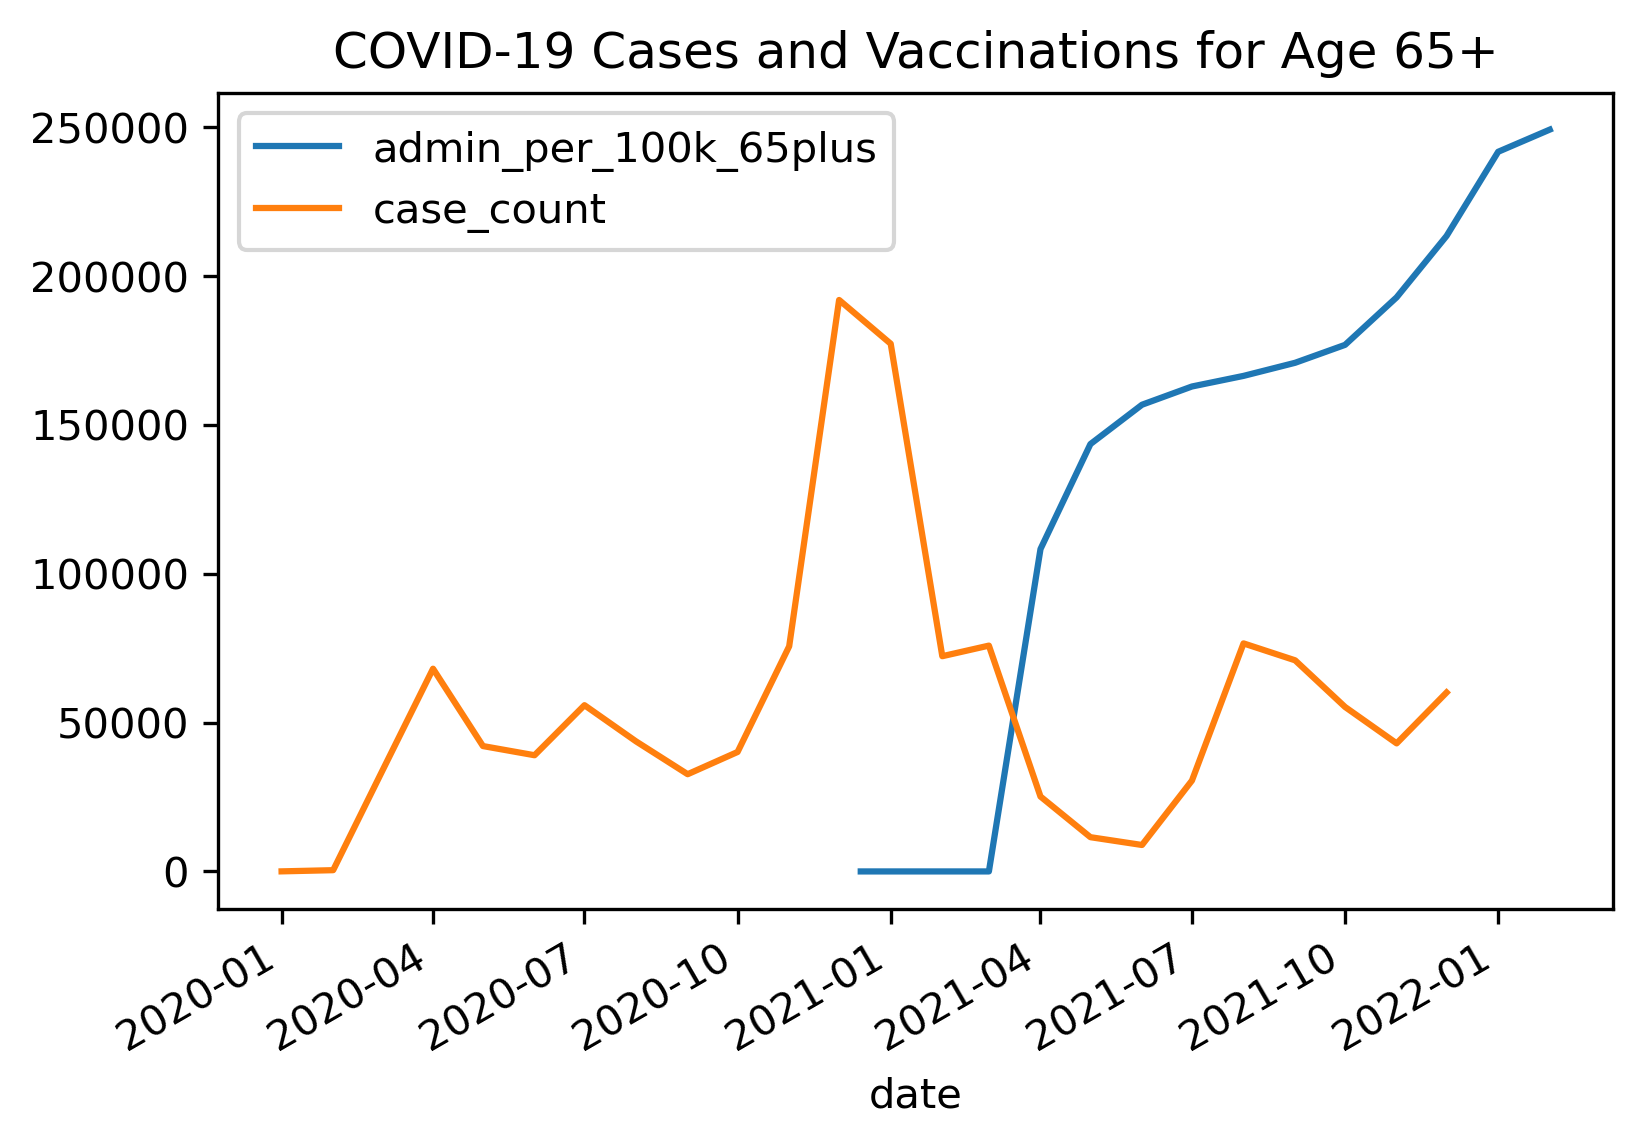

In [51]:
covid65_ax = ny_m_plt.plot(x="date", y="admin_per_100k_65plus", kind="line")
df_covid65.plot(y="case_count", kind="line", ax=covid65_ax, title="COVID-19 Cases and Vaccinations for Age 65+");